This script makes smoothed mcm profiles and also mcm replicate profiles.

In [3]:
# useful imports
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

from scipy.signal import convolve
import peakutils


# useful global variables
# get oridb files to get locations of ars's
oriDB_df = pd.read_csv('oriDB_confirmed_ARSs.bed',  
                 names=['chromosome','start','stop','ars_name'], 
                 delim_whitespace=True, 
                 skiprows=2)

chrX_list = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7',
                 'chr8','chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16']

def get_smooth_reads(bed_file_name = 'orc_chip_sb13/chip_sb13_WT.txt',return_ars_location_dicts=False, smoothing_window_size = 300):
    
    """
    
    This function takes reads aligned to a genome and returns
    smoothed reads. 
    
    Arguments
    ---------
    
    bed_file_name (str): name of file containing reads
                        in the format: 'chromosome','start','stop','reads'
    
    smoothing_window_size (int): integer specifying width of smoothing window
    """
    
    df = pd.read_csv(bed_file_name,
                     names=['chromosome','start','stop','reads'], 
                     delim_whitespace=True, 
                     skiprows=0)

    
    df = df.loc[df['chromosome']!='ref|NC_001224|'].copy()
    
    # lists to contain ars names and widths
    ars_names_total = []
    ars_widths_total = []
    ars_heights_total = []
    
    # list for translating chromosome names from ref|NC_####| 
    # convention to chr#. This is done to increase readability
    chrom_we_want_list=['ref|NC_001133|', 'ref|NC_001134|', 'ref|NC_001135|', 'ref|NC_001136|', 'ref|NC_001137|', 'ref|NC_001138|',
    'ref|NC_001139|', 'ref|NC_001140|', 'ref|NC_001141|', 'ref|NC_001142|', 'ref|NC_001143|', 'ref|NC_001144|',
    'ref|NC_001145|', 'ref|NC_001146|', 'ref|NC_001147|','ref|NC_001148|']

    kb = 1E3

    # dictionaries which can be used for plotting each chromosome profile
    # outside of this loop
    smooth_reads_dict = {}
    smooth_reads_xs_dict = {}
    ars_names_dict = {}
    ars_heights_dict = {}
    ars_heights_xs_dict = {}
    ars_widths_dict = {}
    ars_widths_xs_dict = {}
    peak_locations_dict = {}

    ### start loop here

    for chromosome_index in range(len(chrX_list)):
    #for chromosome_index in range(1):

        chrX_indices = oriDB_df['chromosome']==chrX_list[chromosome_index]    # loop index should go here
        chrom_we_want = chrom_we_want_list[chromosome_index]


        chr2_locations =(oriDB_df[chrX_indices]['start']/kb+oriDB_df[chrX_indices]['stop']/kb)/2.0
        chr2_names = oriDB_df[chrX_indices]['ars_name']

        # Extract values for current chromosome 
        indices = df.loc[:,'chromosome']==chrom_we_want
        chr2_df = df.loc[indices,:]

        # Compute read length
        read_length = df.loc[0,'stop'] - df.loc[0,'start'] + 1

        # Extract vectors of starts, stops, and number of reads
        starts = chr2_df.loc[:,'start'].values
        stops = chr2_df.loc[:,'stop'].values
        num_reads = chr2_df.loc[:,'reads'].astype(float).values

        ### smoothing

        # Create a "kernel" with which to smooth the data
        # from experience, 6 kb is a nice window size
        #window_bp = 300
        window_bp = smoothing_window_size
        read_length = 51
        window_size = window_bp//read_length
        # Create a window kernel so that all elements sum to 1
        window = np.ones(window_size)/window_size

        # Smooth the data by convolving (not convoluting!) the window with the read counts
        smooth_reads = convolve(num_reads,window,'same')
        # recording for plotting later (1)
        smooth_reads_dict[chrX_list[chromosome_index]] = smooth_reads

        ### get peaks
        #max_indices = peakutils.indexes(smooth_reads, thres=0.05, min_dist=100)
        max_indices = peakutils.indexes(smooth_reads, thres=0.2, min_dist=400)

        ### isolate peaks

        # this snippet could be vectorized...

        listbwd = []
        listfwd = []
        yMax = []

        for i in range(len(max_indices)):

            yMax.append(smooth_reads[max_indices[i]])
            indexOfPeakFwd = max_indices[i]
            indexOfPeakBwd = max_indices[i]

            while smooth_reads[indexOfPeakFwd] > yMax[i]/2.0:

                if (indexOfPeakFwd+1) == len(starts):
                    break
                indexOfPeakFwd+=1

            while smooth_reads[indexOfPeakBwd] > yMax[i]/2.0:

                if (indexOfPeakBwd-1) <= 0:
                    break
                indexOfPeakBwd-=1

            listbwd.append(indexOfPeakBwd)
            listfwd.append(indexOfPeakFwd)

        chr2_locations =(oriDB_df[chrX_indices]['start']/kb+oriDB_df[chrX_indices]['stop']/kb)/2.0 

        ###  identify which peaks are ARS
        ars_locations = chr2_locations.values.ravel()
        peak_locations = starts[max_indices]/kb
        
        peak_locations_per_chromosome_list = []
        for peak_index in range(len(max_indices)):
            peak_locations_per_chromosome_list.append((starts[max_indices[peak_index]]+stops[max_indices[peak_index]])/(2))
            
        peak_locations_dict[chrX_list[chromosome_index]] = peak_locations_per_chromosome_list                    
        
        
        ### get indices of clean ARS-Peaks combos

        clean_peak_indices = []

        # get index of closest numer
        def closest(list, Number):
            aux = []
            for valor in list:
                aux.append(abs(Number-valor))

            return aux.index(min(aux))

        for ipeak in range(len(peak_locations)):
            #print(closest(ars_locations,peak_locations[ipeak]))
            clean_peak_indices.append(closest(ars_locations,peak_locations[ipeak]))


        ### record all ars heights
        x = 0.5*(starts+stops)/kb
        L = max(x)
        # recording for plotting later (2)
        smooth_reads_xs_dict[chrX_list[chromosome_index]] = x

        # index array of where ars's are locations
        indices_of_ars_locations = [] 

        # get index of closest numer
        def closest(list, Number):
            aux = []
            for valor in list:
                aux.append(abs(Number-valor))

            return aux.index(min(aux))

        for ith_ars_location in range(len(ars_locations)):    
            indices_of_ars_locations.append(closest(x,ars_locations[ith_ars_location]))

        # the heights of ars according to the smoothed profile    
        #smooth_reads[indices_of_ars_locations] 

        for append_index in range(len(chr2_names.tolist())):
            # record heights and names of the ars for the current chromosome
            ars_names_total.append(chr2_names.tolist()[append_index])
            ars_heights_total.append(smooth_reads[indices_of_ars_locations].tolist()[append_index])

        ars_names_dict[chrX_list[chromosome_index]] = chr2_names.tolist()
        ars_heights_dict[chrX_list[chromosome_index]] = smooth_reads[indices_of_ars_locations].tolist()
        ars_heights_xs_dict[chrX_list[chromosome_index]] = ars_locations

    ### store height results

    # append the following three in a dataframe
    #ars_locations    
    #smooth_reads[indices_of_ars_locations]
    # contains ars names
    #chr2_names

    # put everything in a dataframe
    ars_height_df = pd.DataFrame(
        {'ARS': ars_names_total,
         'Heights': ars_heights_total
        })

    # Read Genome wide confirmed ARSs (Nieduszynski et. al.)

    ars_location_table_raw = pd.read_csv('table_S1_Clean.csv',  
                     names=['paper_name','name','chromosome','position','A_element',
                            'Strand','Species Avail','Cons-Species','Cons-Score','Score-Mast',
                            '5-Prime','3-Prime','ARS-activity','assay data'
                           ], 
                     sep=',', 
                     skiprows=0)

    # Change Conrad Supplement Table to ORIdb format to re-use code from before
    ars_location_table_raw['chromosome'] = 'chr' + ars_location_table_raw['chromosome'].astype(str)
    ars_location_table_raw['name'] = 'ARS' + ars_location_table_raw['name'].astype(str)
    
    Nieduszynski_df = pd.DataFrame(
                                  {'chromosome':ars_location_table_raw['chromosome'].tolist(),
                                  'position':ars_location_table_raw['position'].tolist(),
                                  'name':ars_location_table_raw['name'].tolist(),
                                  'sequence':ars_location_table_raw['A_element'].tolist(), 
                                  'strand':ars_location_table_raw['Strand'].tolist()
                                  }
                                  )


    # to match the annotated ARS position with the nearest position of the smoothed_read xs
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        #return array[idx],idx
        return idx


    heights_at_conrad_ars_location_dict = {}


    for current_chromosome in chrX_list:
        #print(current_chromosome)

        ars_names_list_conrad = Nieduszynski_df.loc[Nieduszynski_df['chromosome'] == current_chromosome]['name'].tolist()
        ars_position_list_conrad = Nieduszynski_df.loc[Nieduszynski_df['chromosome'] == current_chromosome]['position'].tolist()

        heights_at_conrad_ars_location = []

        #smooth_reads_xs_dict
        for ars_pos_index in range(len(ars_position_list_conrad)):
            #ars_conrad_height_index = find_nearest(xs, ars_position_list_conrad[ars_pos_index]/kb)
            ars_conrad_height_index = find_nearest(smooth_reads_xs_dict[current_chromosome], ars_position_list_conrad[ars_pos_index]/kb)
            #print(smooth_reads_dict[chromosome_to_plot][ars_conrad_height_index])
            heights_at_conrad_ars_location.append(smooth_reads_dict[current_chromosome][ars_conrad_height_index])

        heights_at_conrad_ars_location_dict[current_chromosome] = heights_at_conrad_ars_location
    
    if(return_ars_location_dicts==False):
        return smooth_reads_dict,smooth_reads_xs_dict, Nieduszynski_df, peak_locations_dict
    else:
        return smooth_reads_dict,smooth_reads_xs_dict, Nieduszynski_df, heights_at_conrad_ars_location_dict


# normalizaton using 99.5 percentile across genome
def percentile_across_genome(input_dict):
    
    # take entire genome dict values and put them in this list
    concatenated_list = []
    
    for dict_index in range(len(input_dict.values())):
        for array_index in range(len(input_dict.values()[dict_index])):
            concatenated_list.append(input_dict.values()[dict_index][array_index])
            
    #return 99.5 percentile value which to normalize with
    return np.percentile(concatenated_list,99.5)



# further useful global variables
lightblue = [0, .5, 1]
orange = [1,0.5,0]

figure_size = [28,7]
label_size = 20
title_size = 20
kb=1E3

## Load mcm files into dicts for plotting

In [5]:
WT_ys_c_mcm, WT_xs_c_mcm, Nieduszynski_df_c_mcm, WT_peaks_c_mcm = get_smooth_reads(bed_file_name='mcm_data/chip_mcm_WT_08272019.txt')
N489A_ys_c_mcm, N489A_xs_c_mcm, Nieduszynski_df_c_mcm, N489A_peaks_c_mcm = get_smooth_reads(bed_file_name='mcm_data/chip_mcm_N489A_08272019.txt')
mrc1D_ys_c_mcm, mrc1D_xs_c_mcm, Nieduszynski_df_c_mcm, mrc1D_peaks_c_mcm = get_smooth_reads(bed_file_name='mcm_data/chip_mcm_mrc1_08272019.txt')
F485I_ys_c_mcm, F485I_xs_c_mcm, Nieduszynski_df_c_mcm,F485I_peaks_c_mcm = get_smooth_reads(bed_file_name='mcm_data/chip_mcm_F485I_08272019.txt')
F485I_Y486Q_ys_c_mcm, F485I_Y486Q_xs_c_mcm, Nieduszynski_df_c_mcm,F485I_Y486Q_peaks_c_mcm = get_smooth_reads(bed_file_name='mcm_data/chip_mcm_F485I_Y486Q_08272019.txt')
F485A_Y486A_ys_c_mcm, F485A_Y486A_xs_c_mcm, Nieduszynski_df_c_mcm,F485A_Y486A_peaks_c_mcm = get_smooth_reads(bed_file_name='mcm_data/chip_mcm_F485A_Y486A_08272019.txt')



## Load mcm replicate files into dicts for plotting

In [11]:
WT_ys_c_mcm_rep2, WT_xs_c_mcm_rep2, Nieduszynski_df_c_mcm_rep2, WT_peaks_c_mcm_rep2 = get_smooth_reads(bed_file_name='mcm_data_replicate/chip_mcm_WT_rep2.txt')
N489A_ys_c_mcm_rep2, N489A_xs_c_mcm_rep2, Nieduszynski_df_c_mcm_rep2, N489A_peaks_c_mcm_rep2 = get_smooth_reads(bed_file_name='mcm_data_replicate/chip_mcm_N489A_rep2.txt')
F485I_ys_c_mcm_rep2, F485I_xs_c_mcm_rep2, Nieduszynski_df_c_mcm_rep2,F485I_peaks_c_mcm_rep2 = get_smooth_reads(bed_file_name='mcm_data_replicate/chip_mcm_FI_YQ_rep2.txt')
F485I_Y486Q_ys_c_mcm_rep2, F485I_Y486Q_xs_c_mcm_rep2, Nieduszynski_df_c_mcm_rep2,F485I_Y486Q_peaks_c_mcm_rep2 = get_smooth_reads(bed_file_name='mcm_data_replicate/chip_mcm_FA_YA_rep2.txt')
F485A_Y486A_ys_c_mcm_rep2, F485A_Y486A_xs_c_mcm_rep2, Nieduszynski_df_c_mcm_rep2,F485A_Y486A_peaks_c_mcm_rep2 = get_smooth_reads(bed_file_name='mcm_data_replicate/chip_mcm_F485I_rep2.txt')
mrc1D_ys_c_mcm_rep2, mrc1D_xs_c_mcm_rep2, Nieduszynski_df_c_mcm_rep2, mrc1D_peaks_c_mcm_rep2 = get_smooth_reads(bed_file_name='mcm_data_replicate/chip_mcm_mrc1_rep2.txt')


### MCM profiles

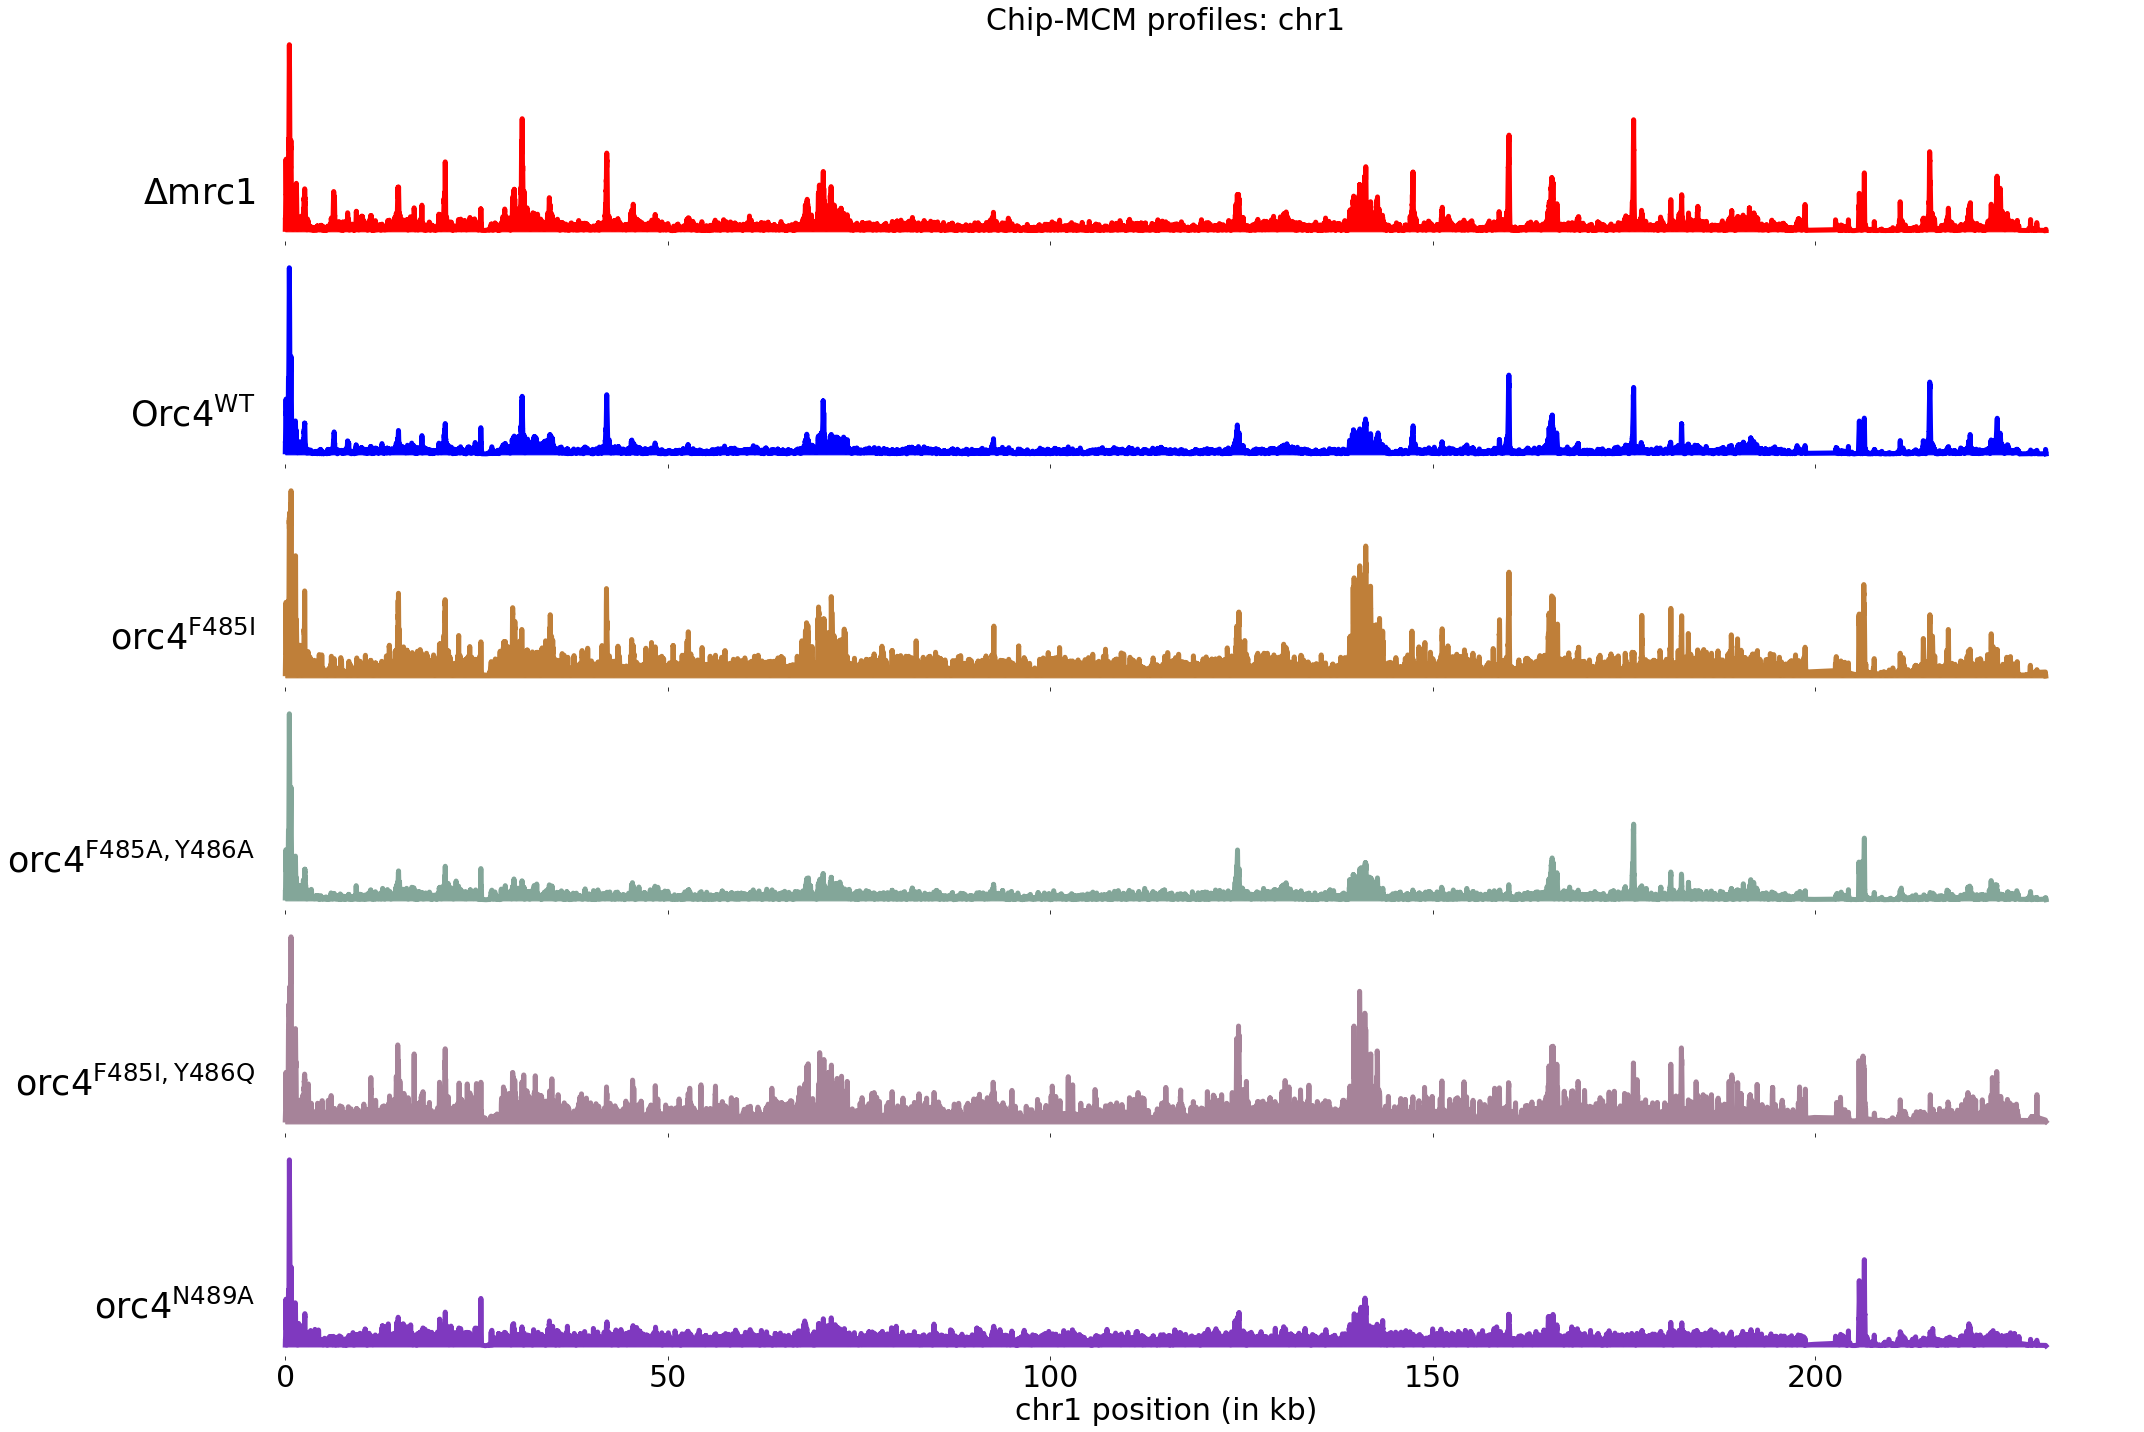

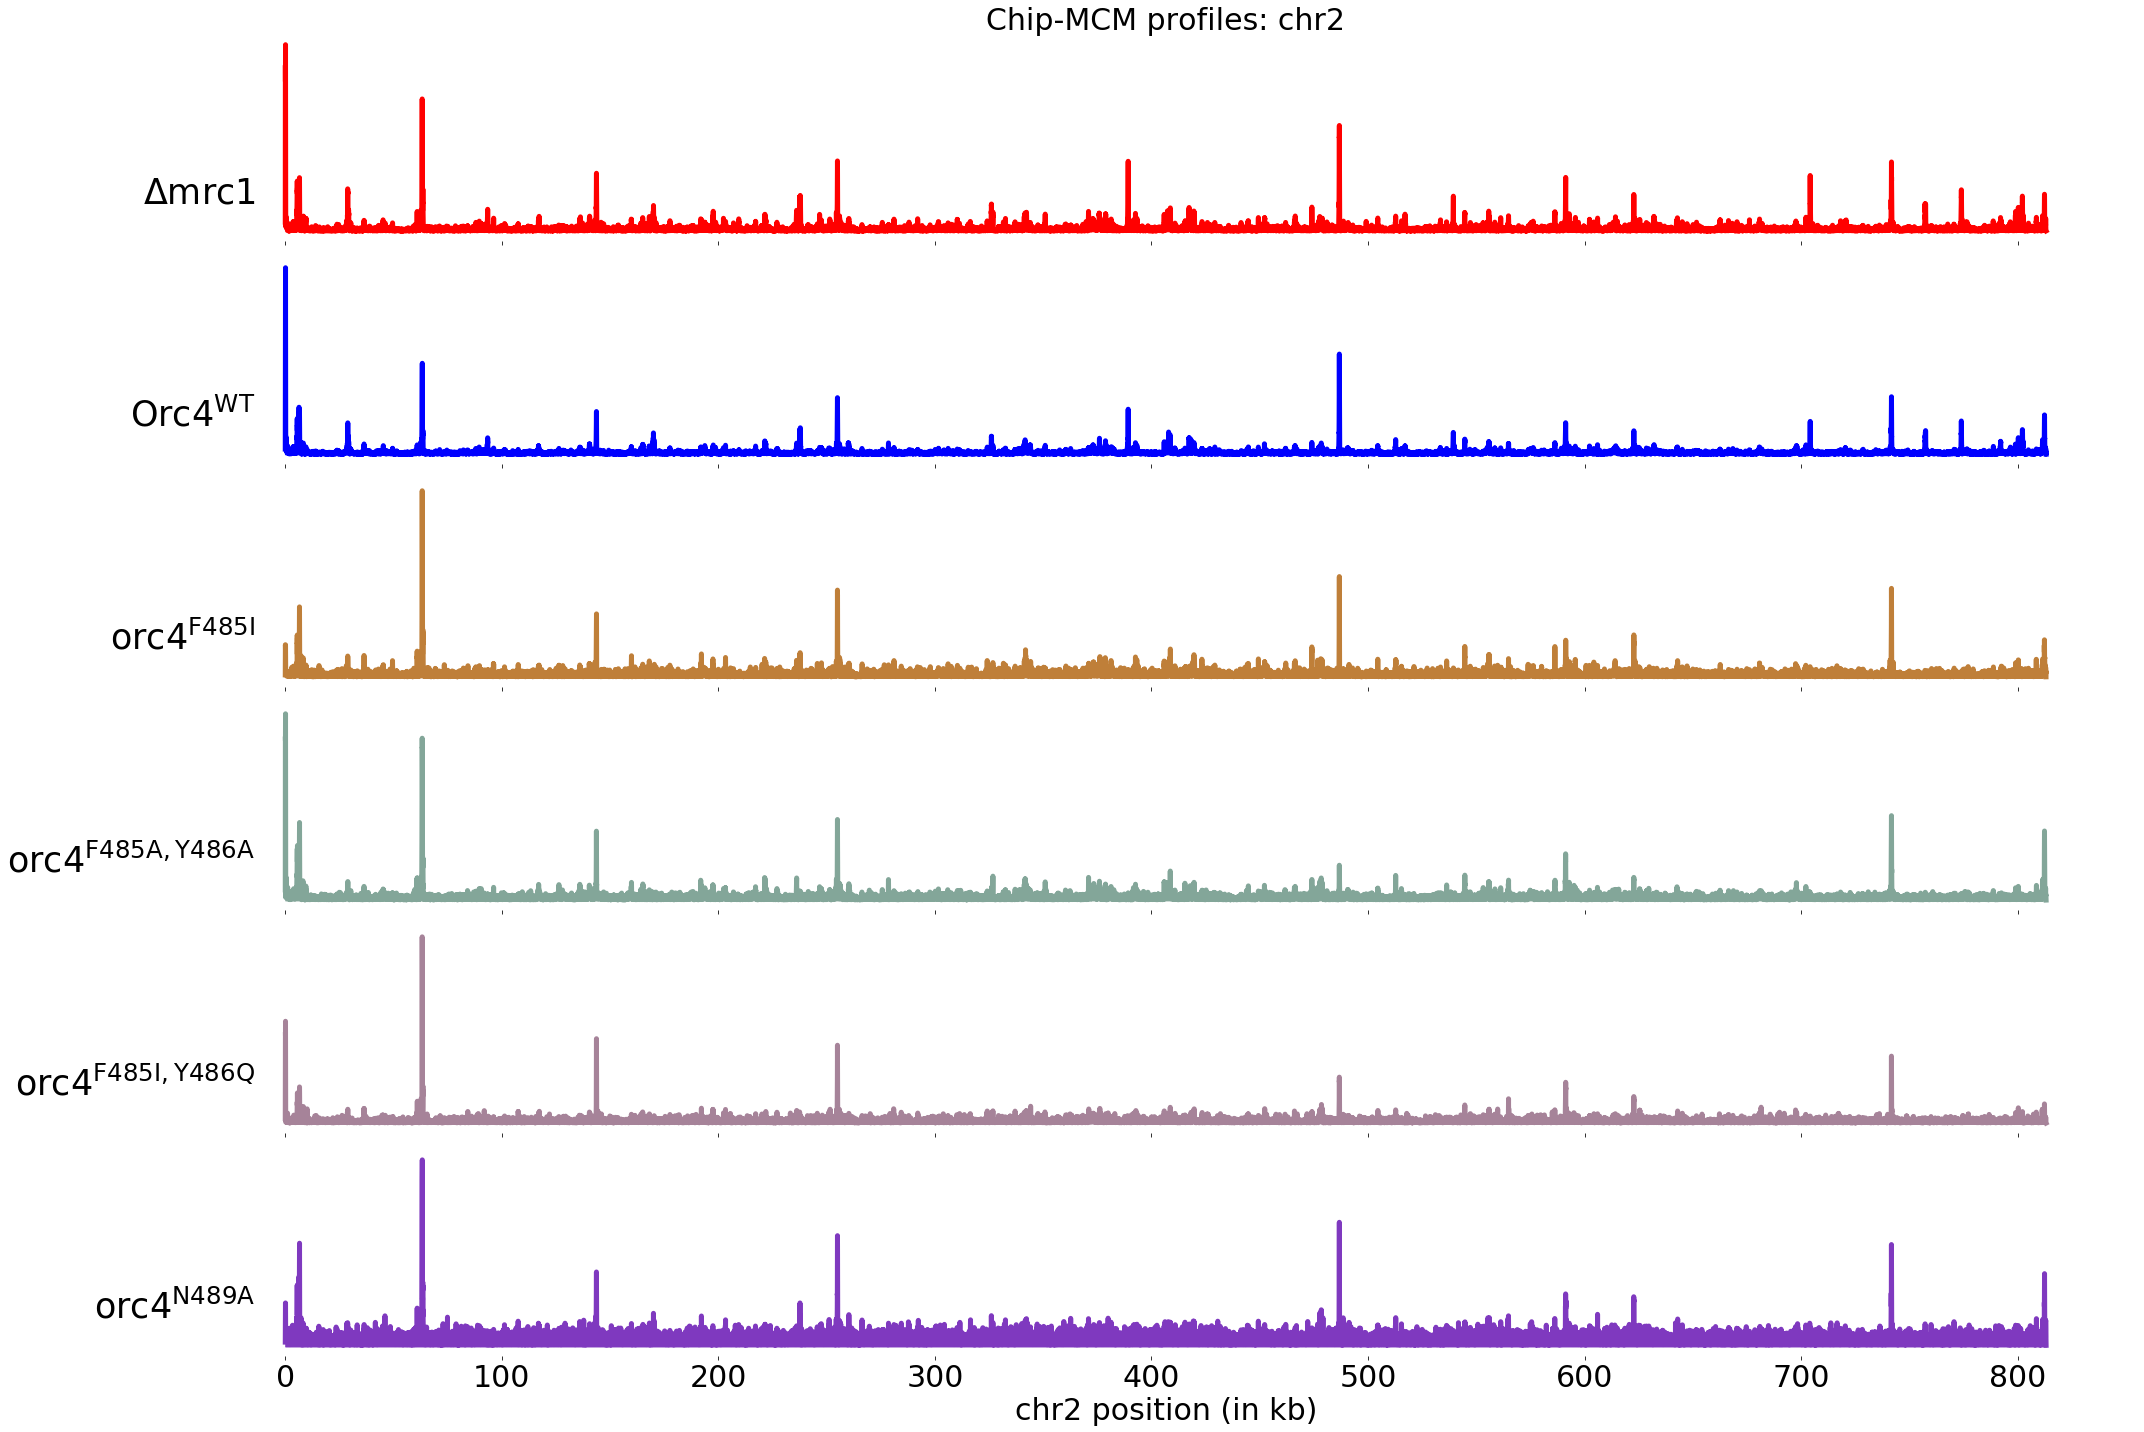

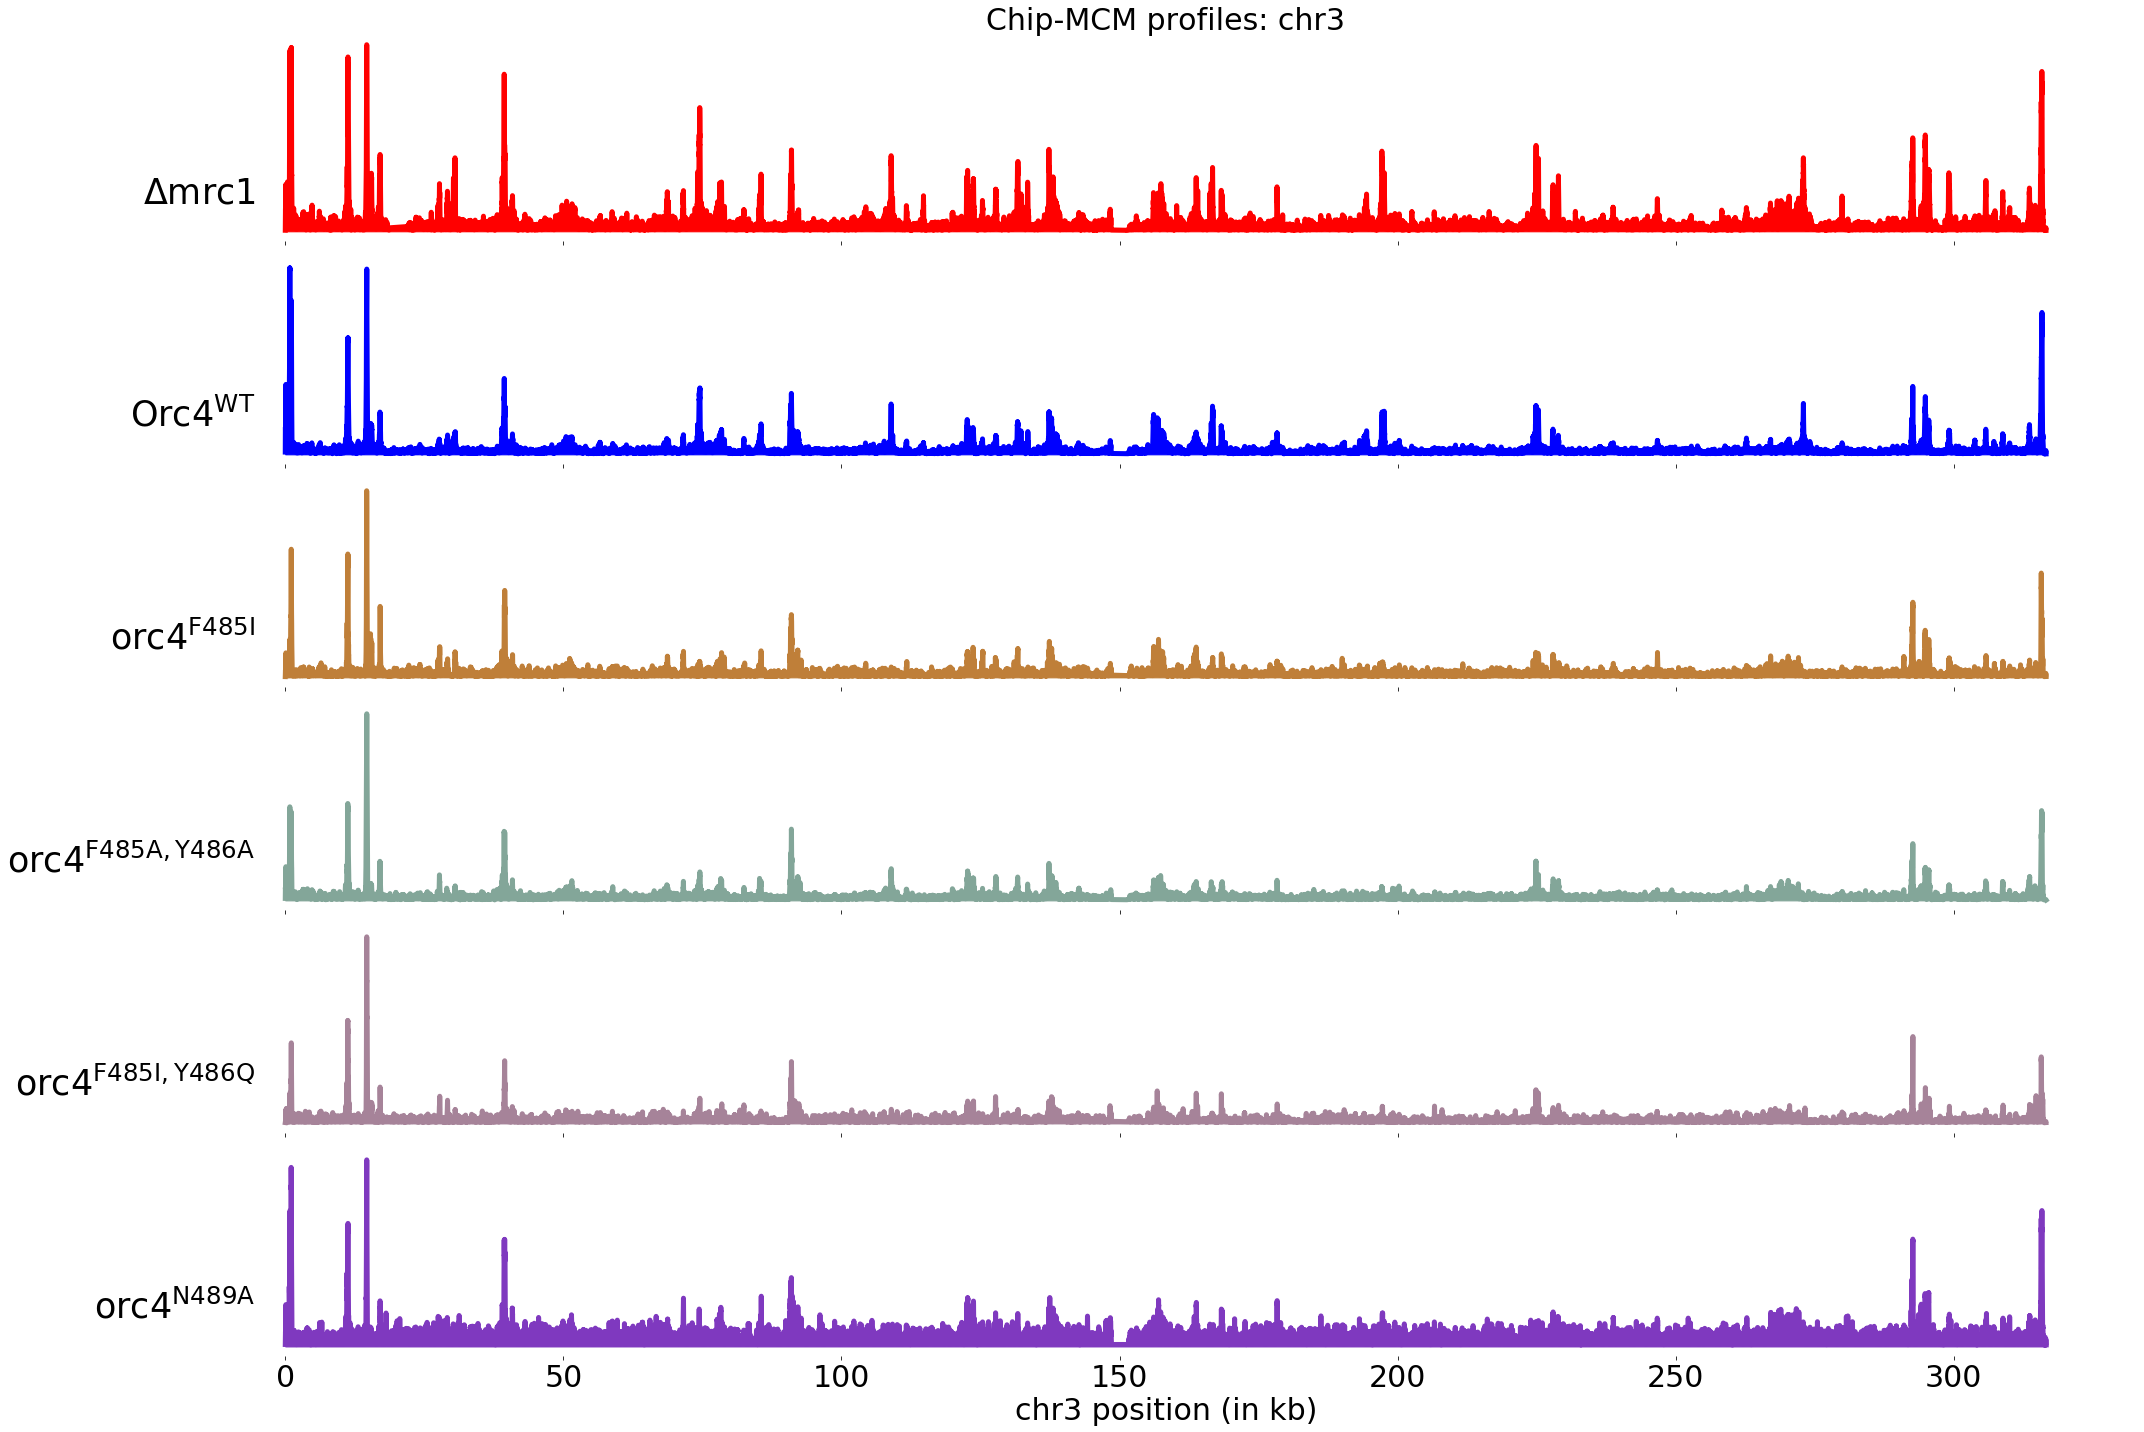

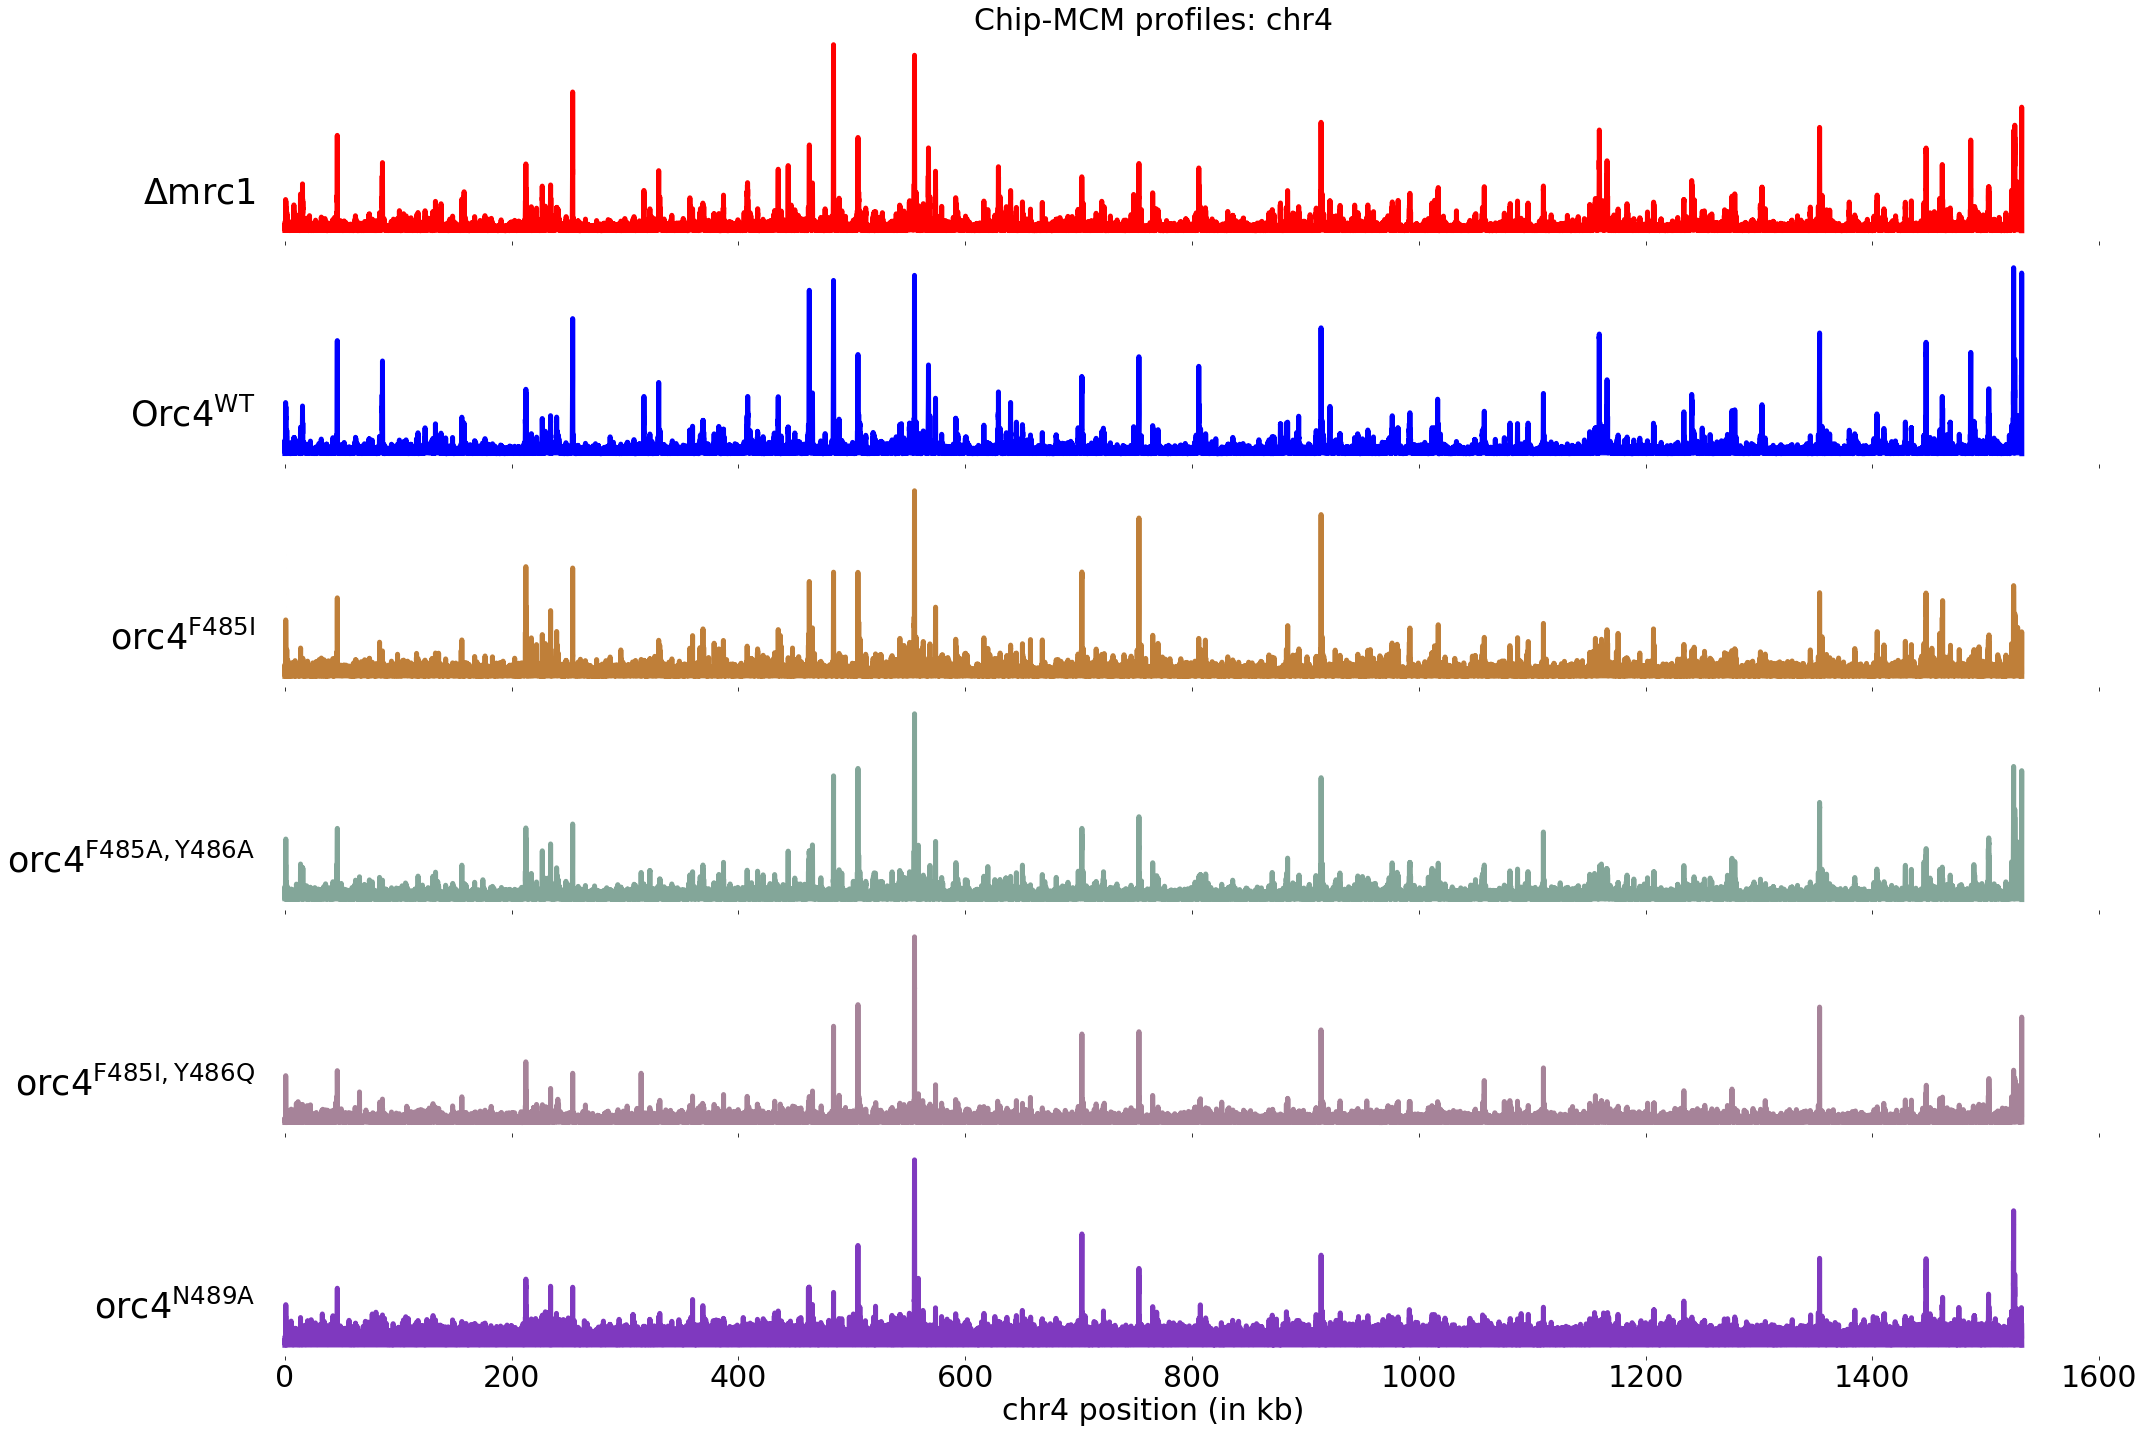

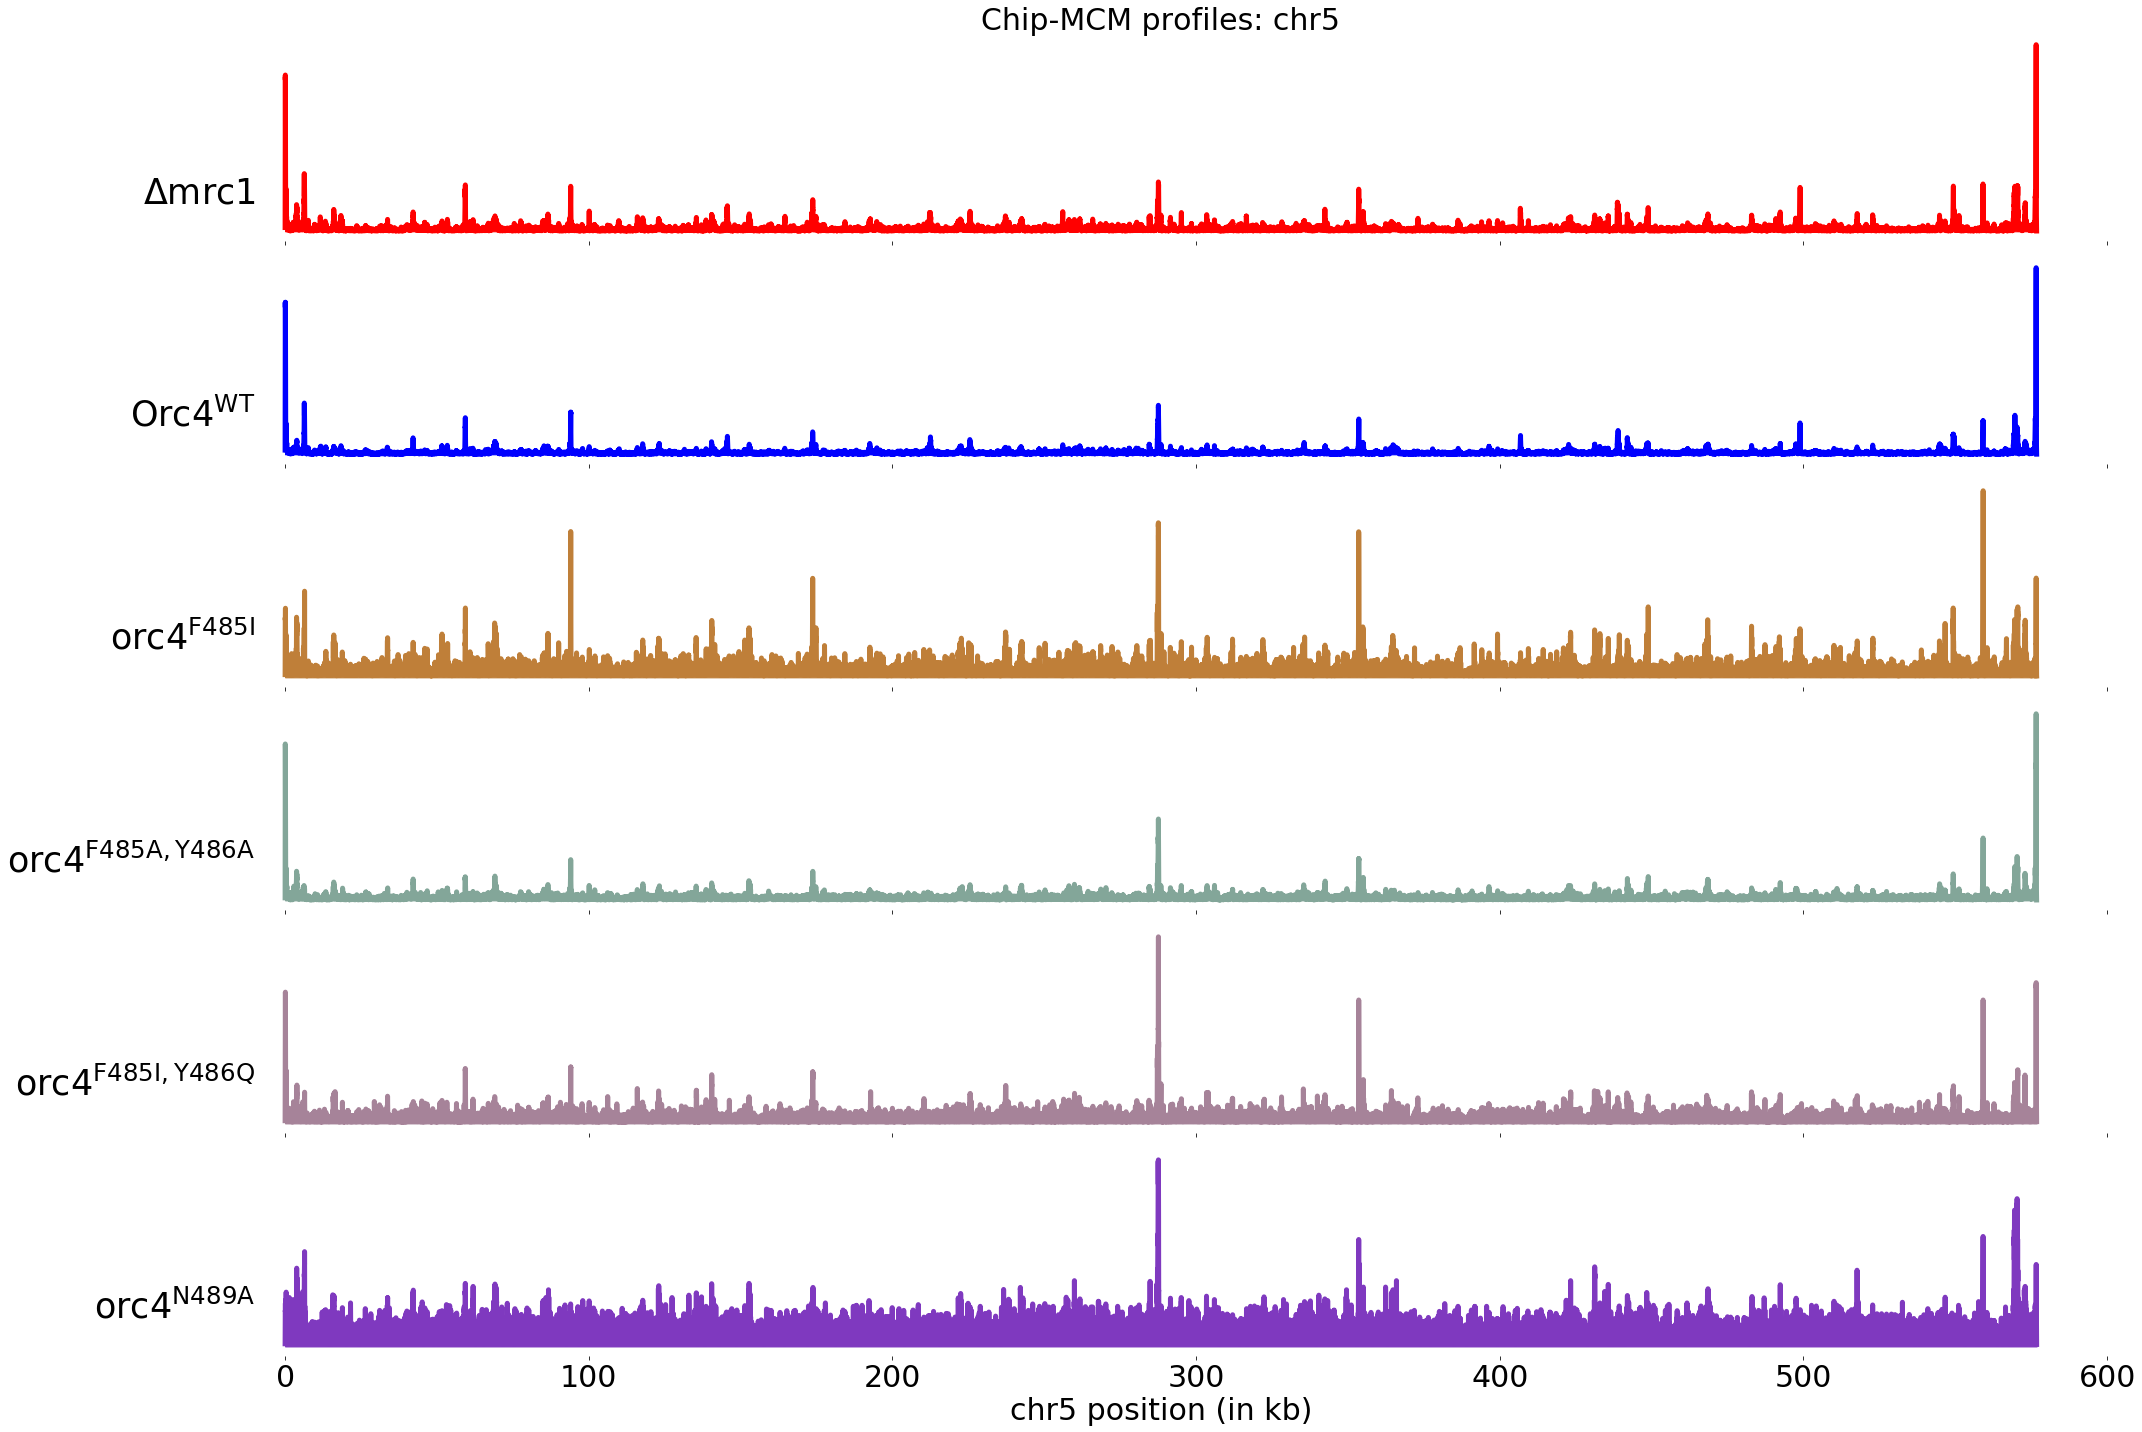

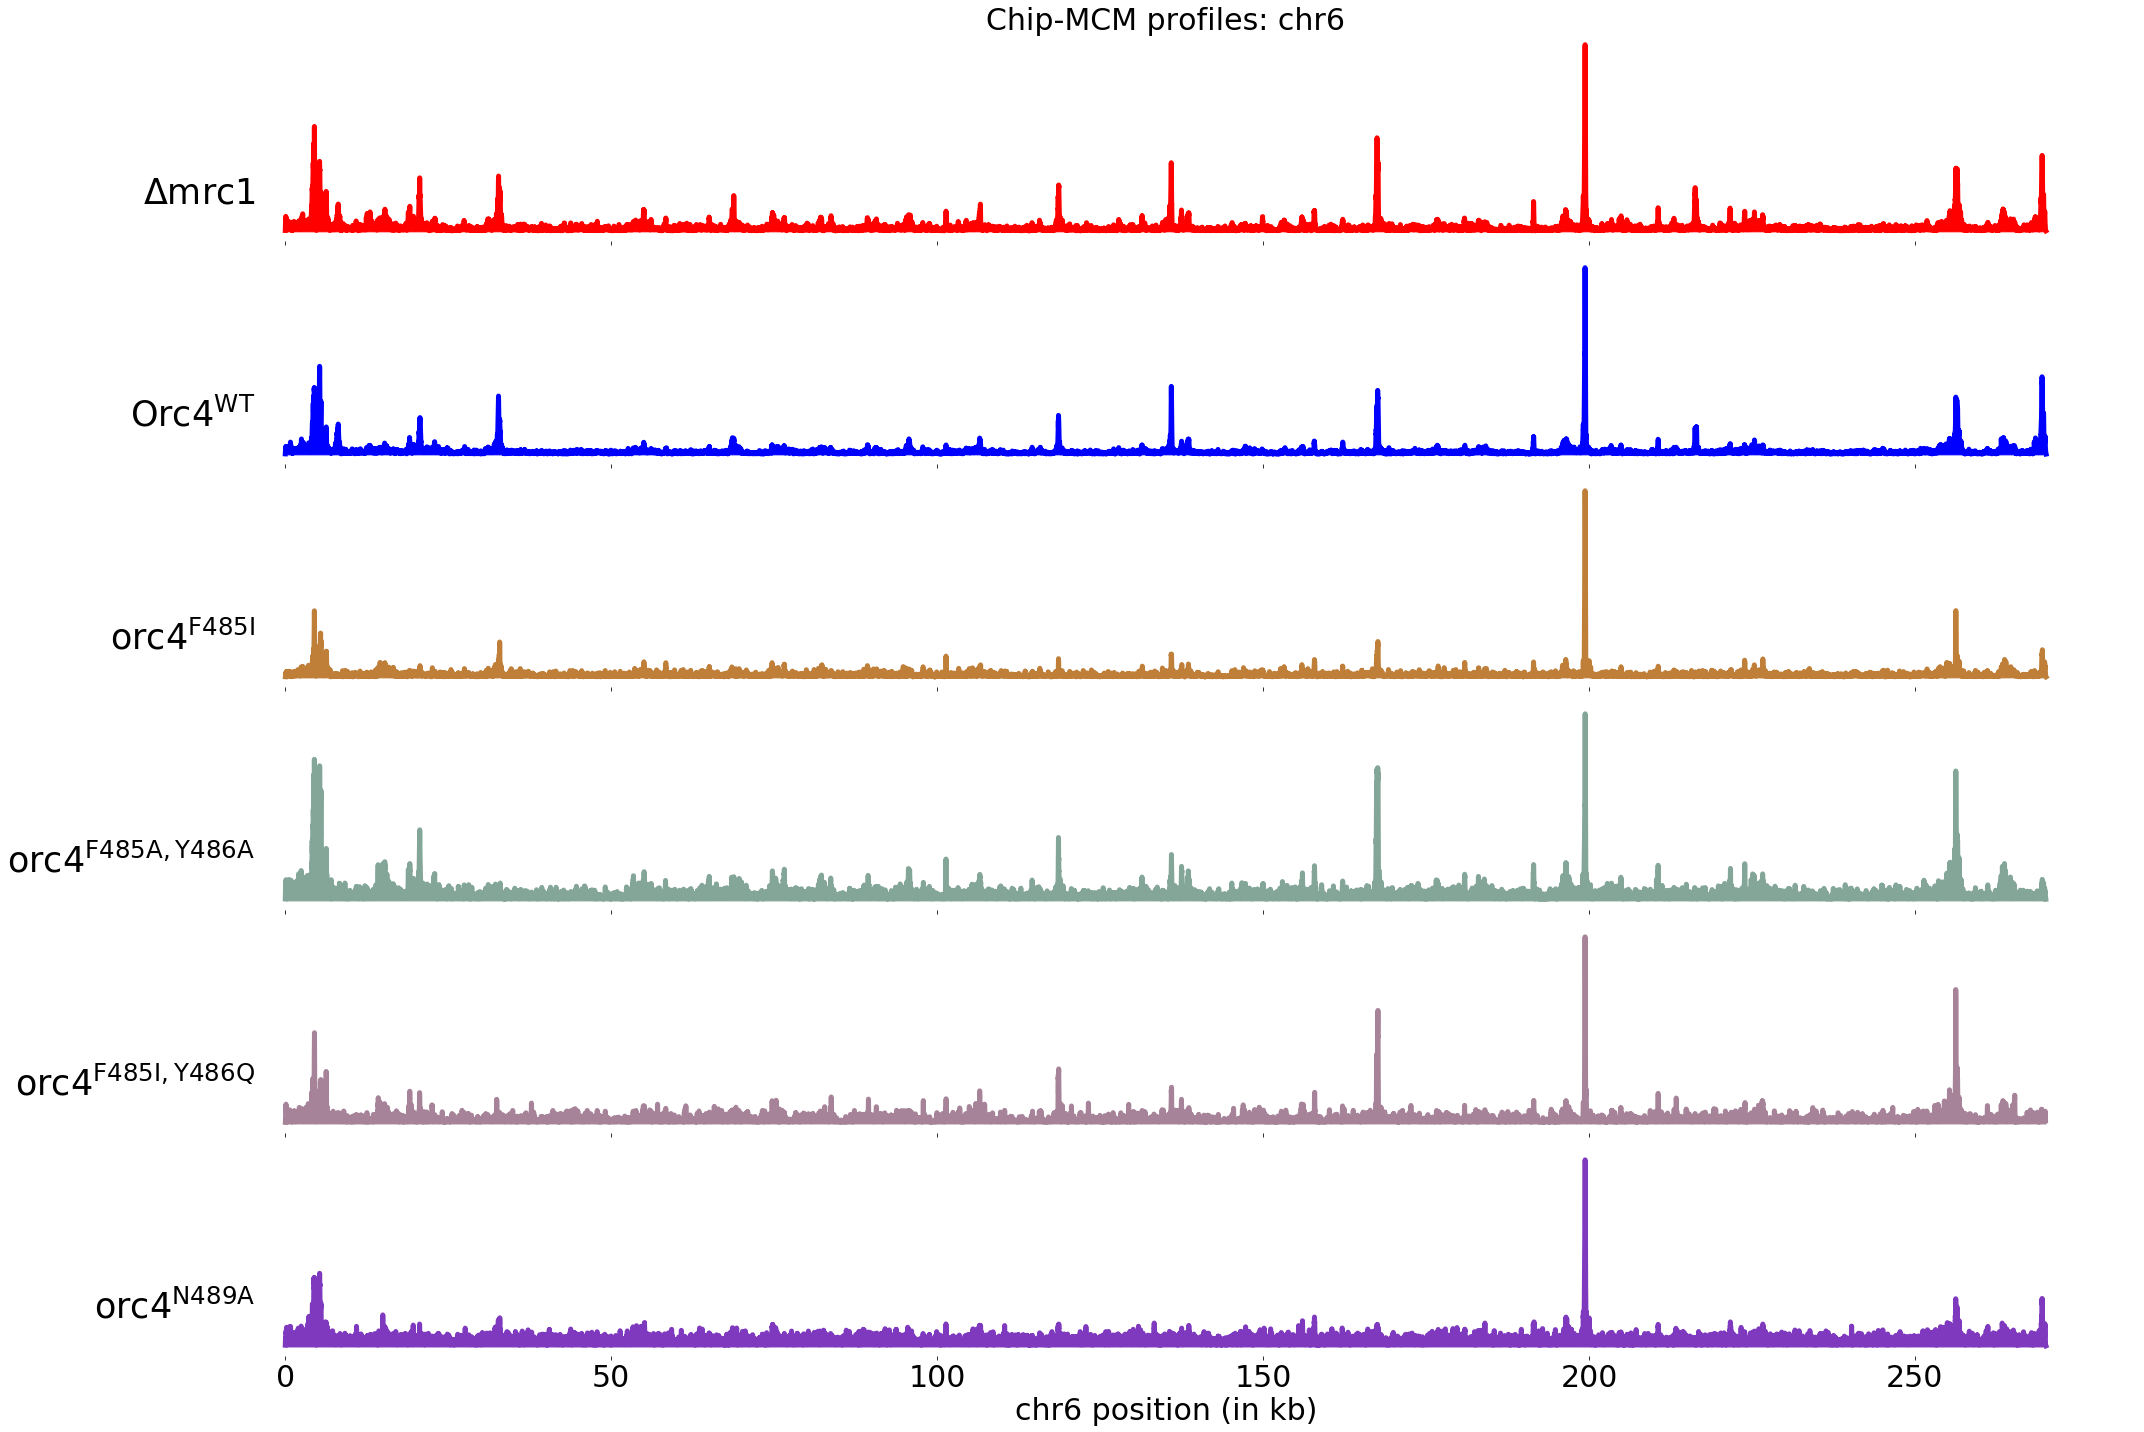

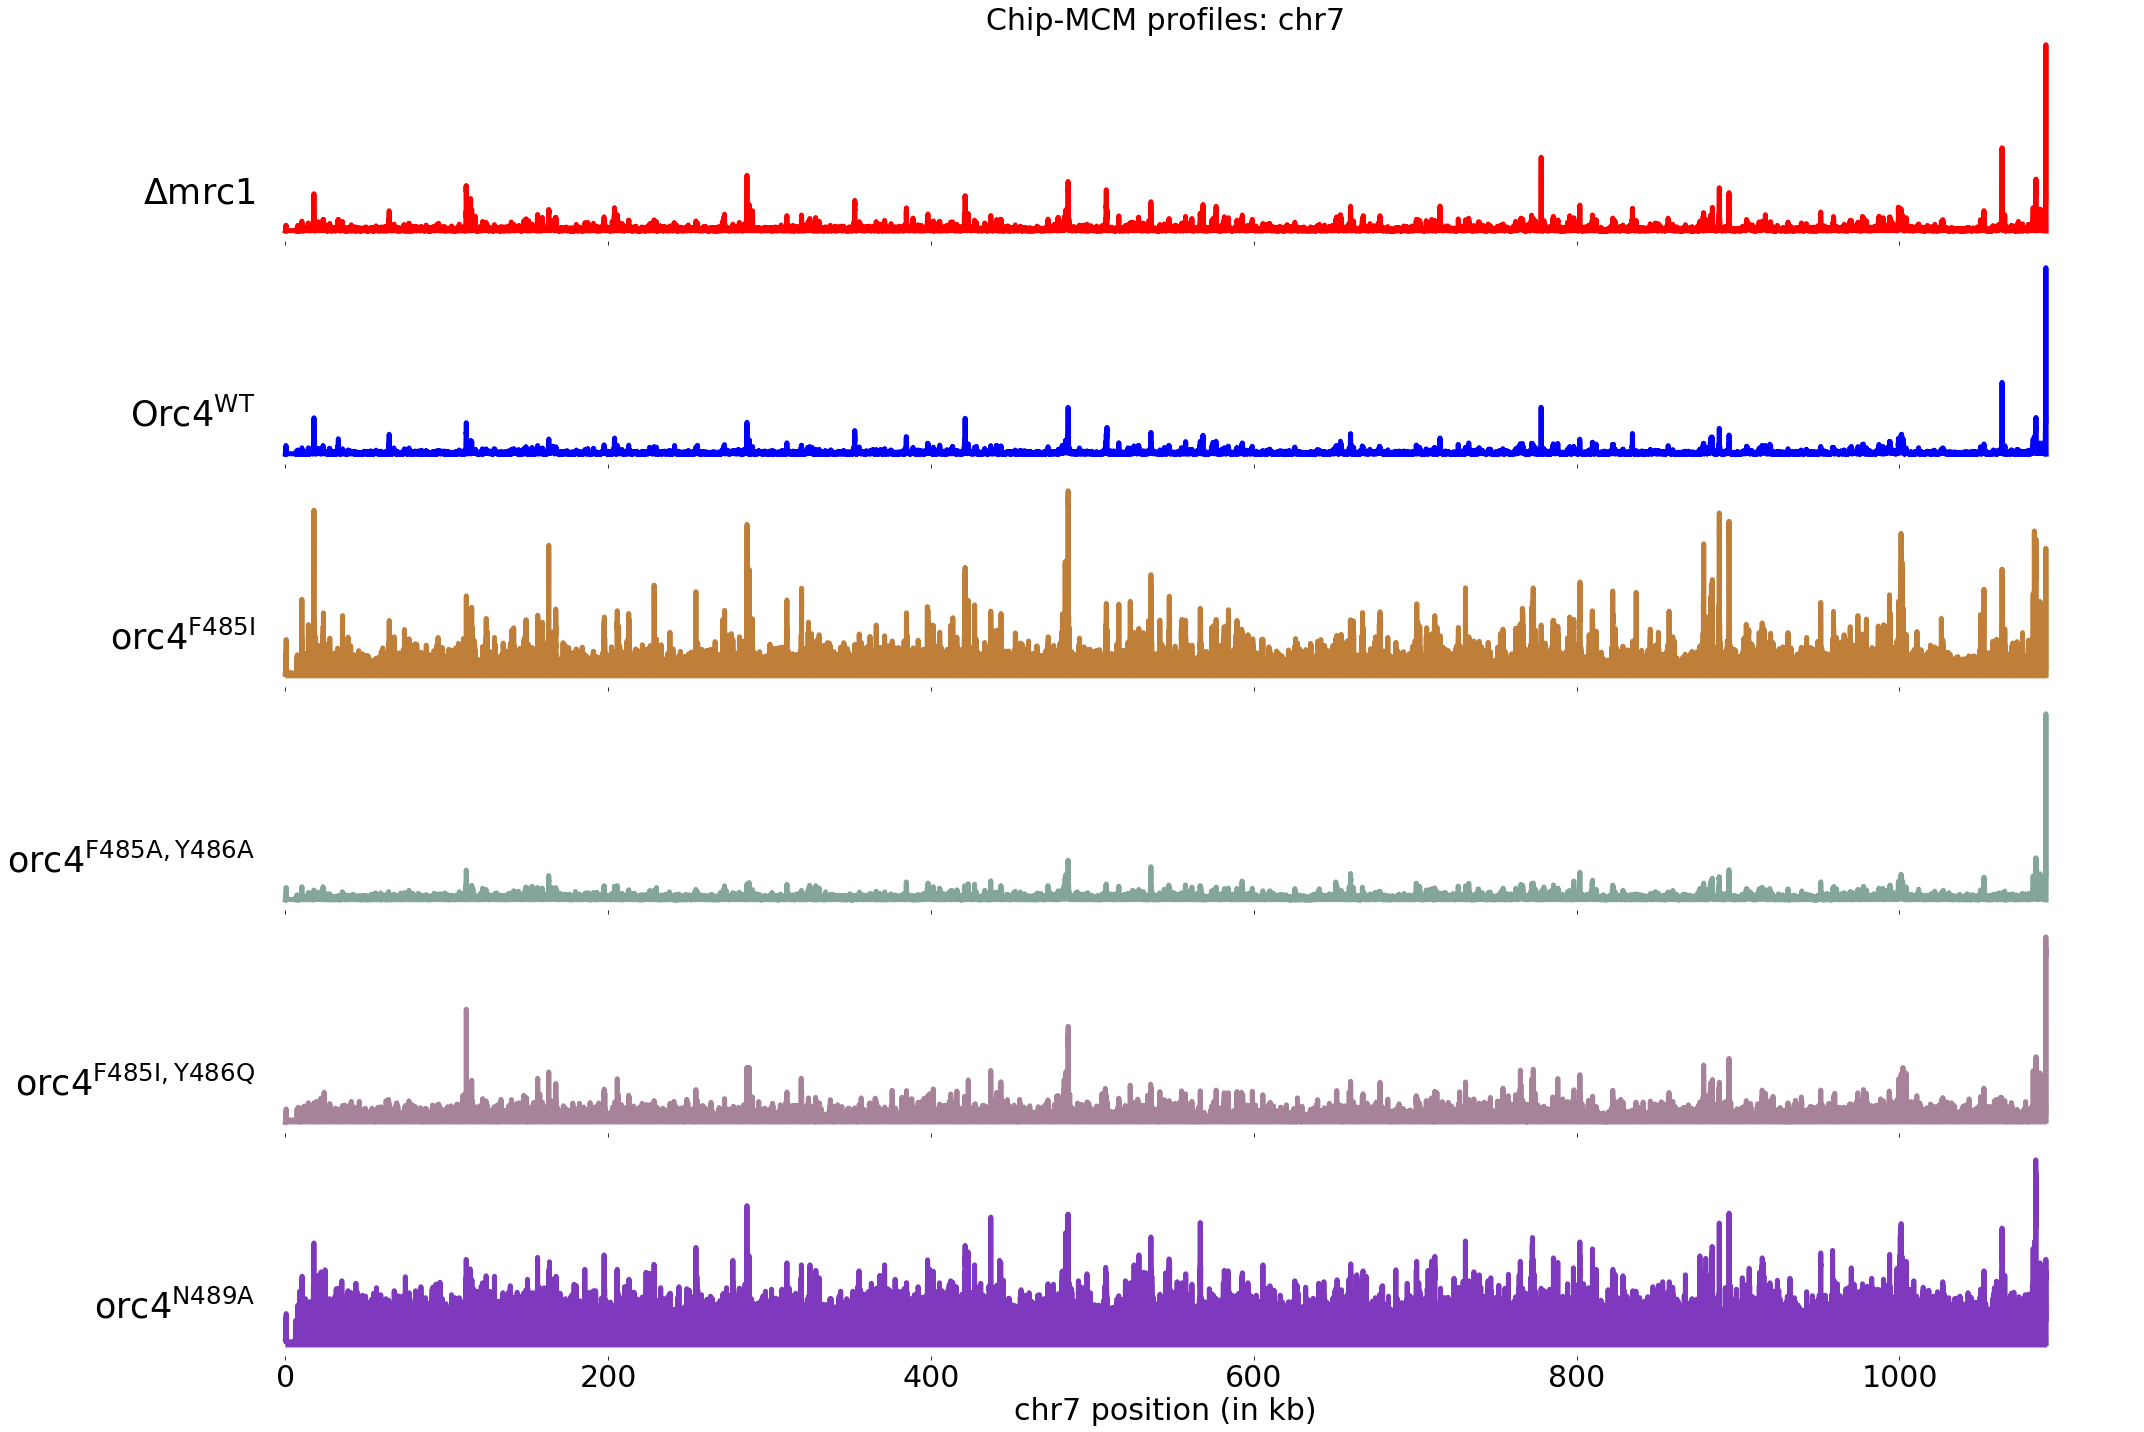

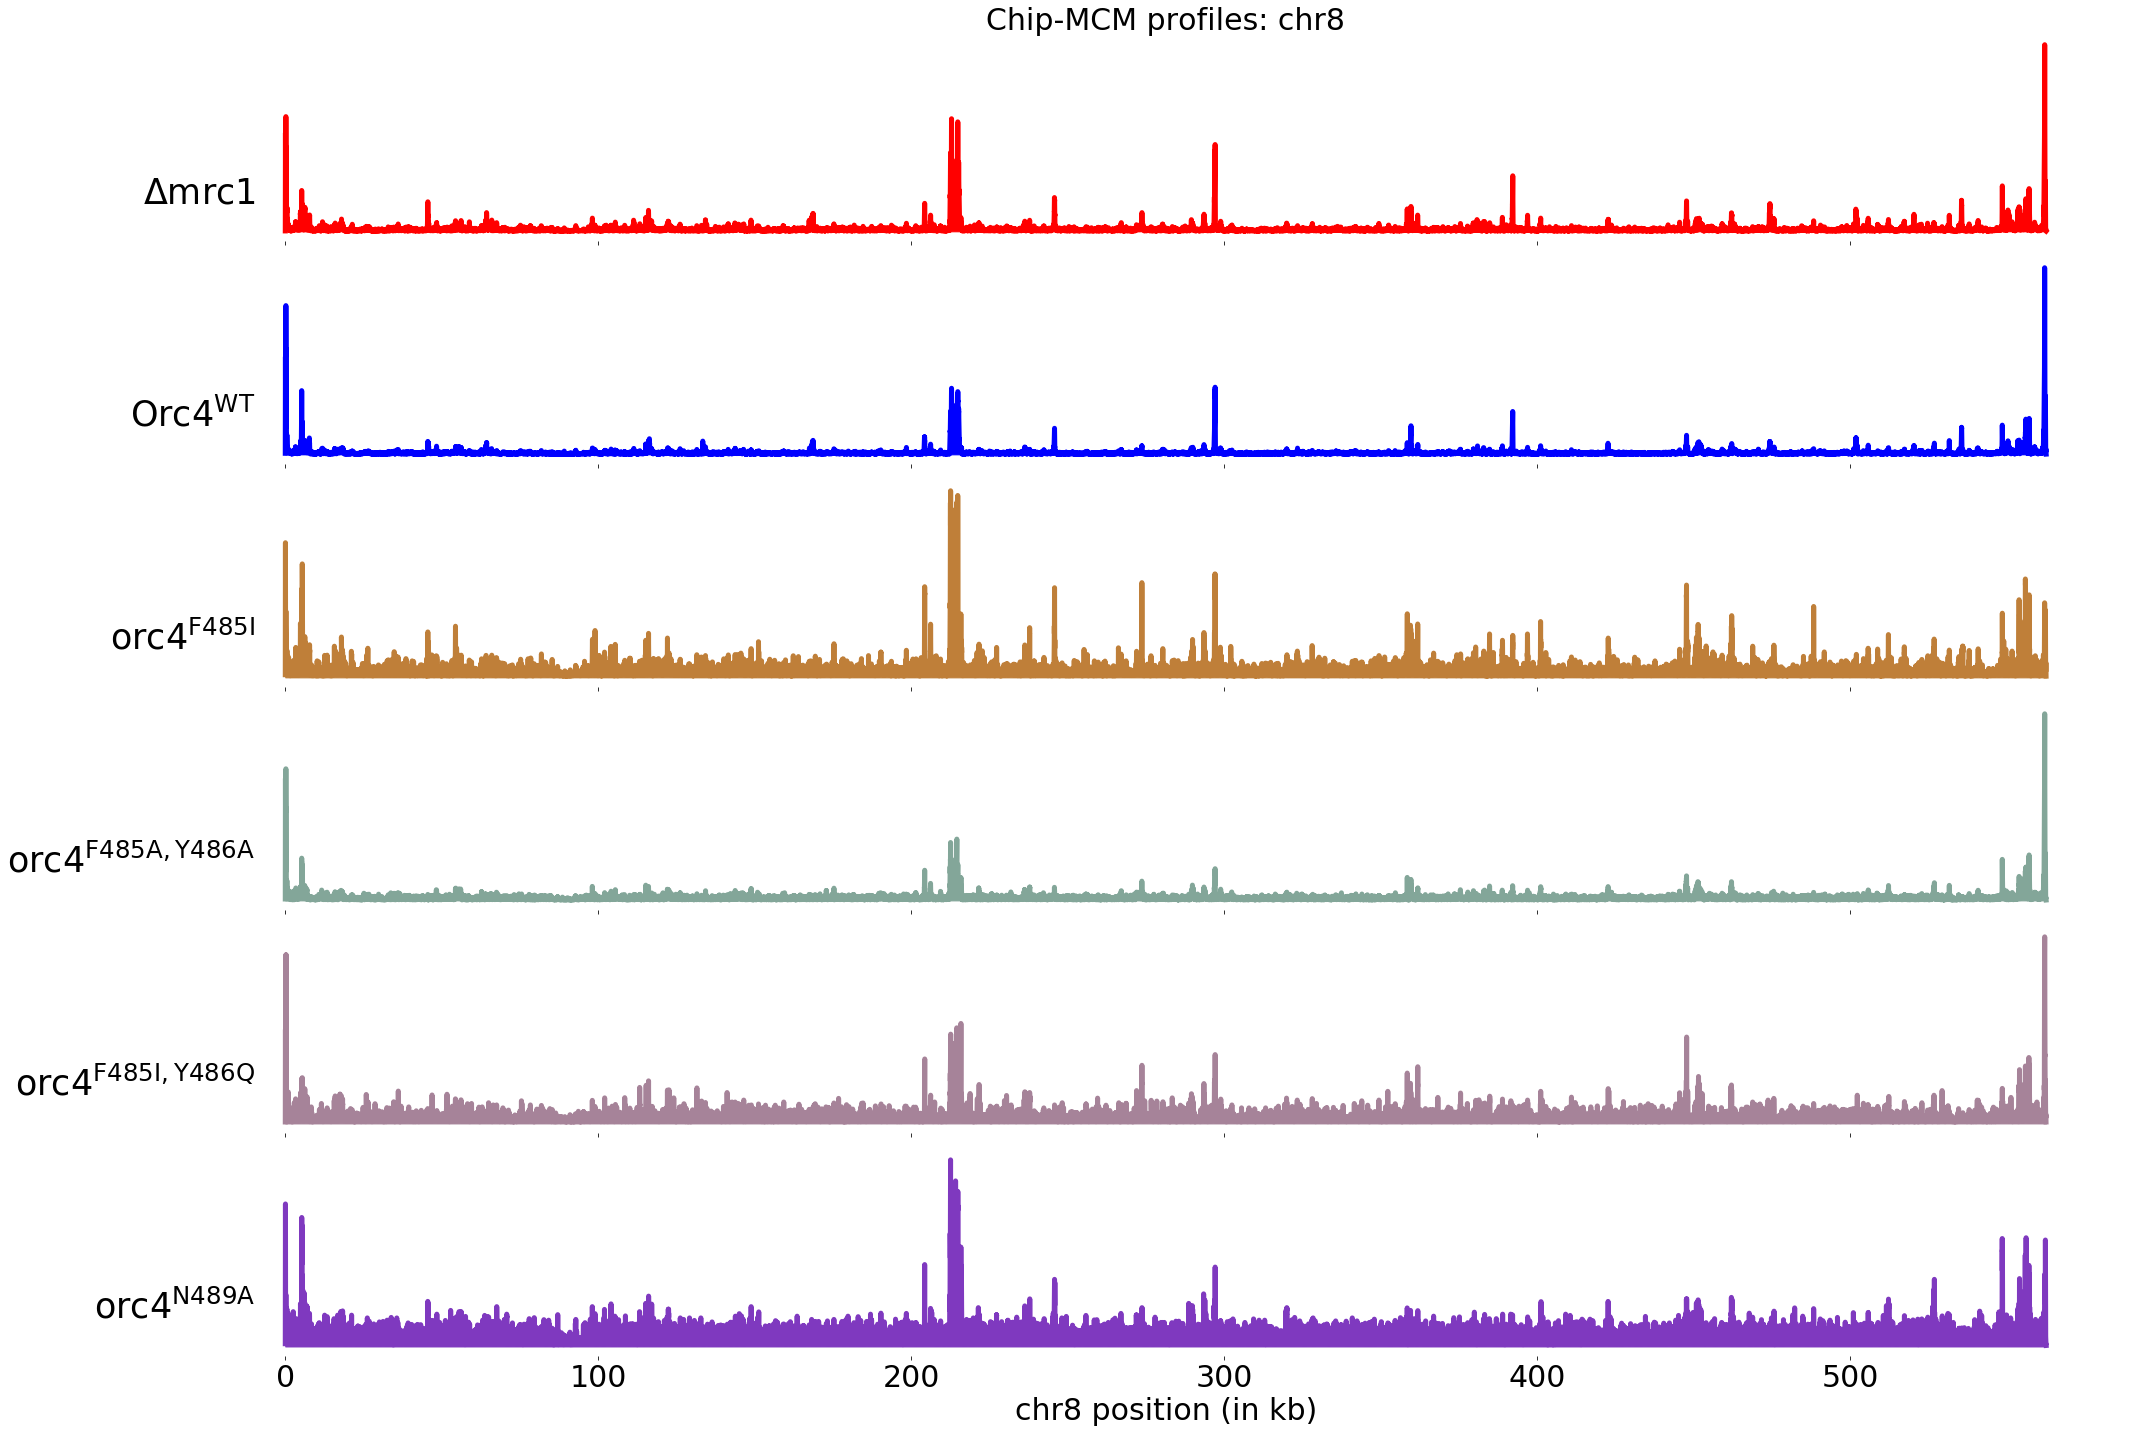

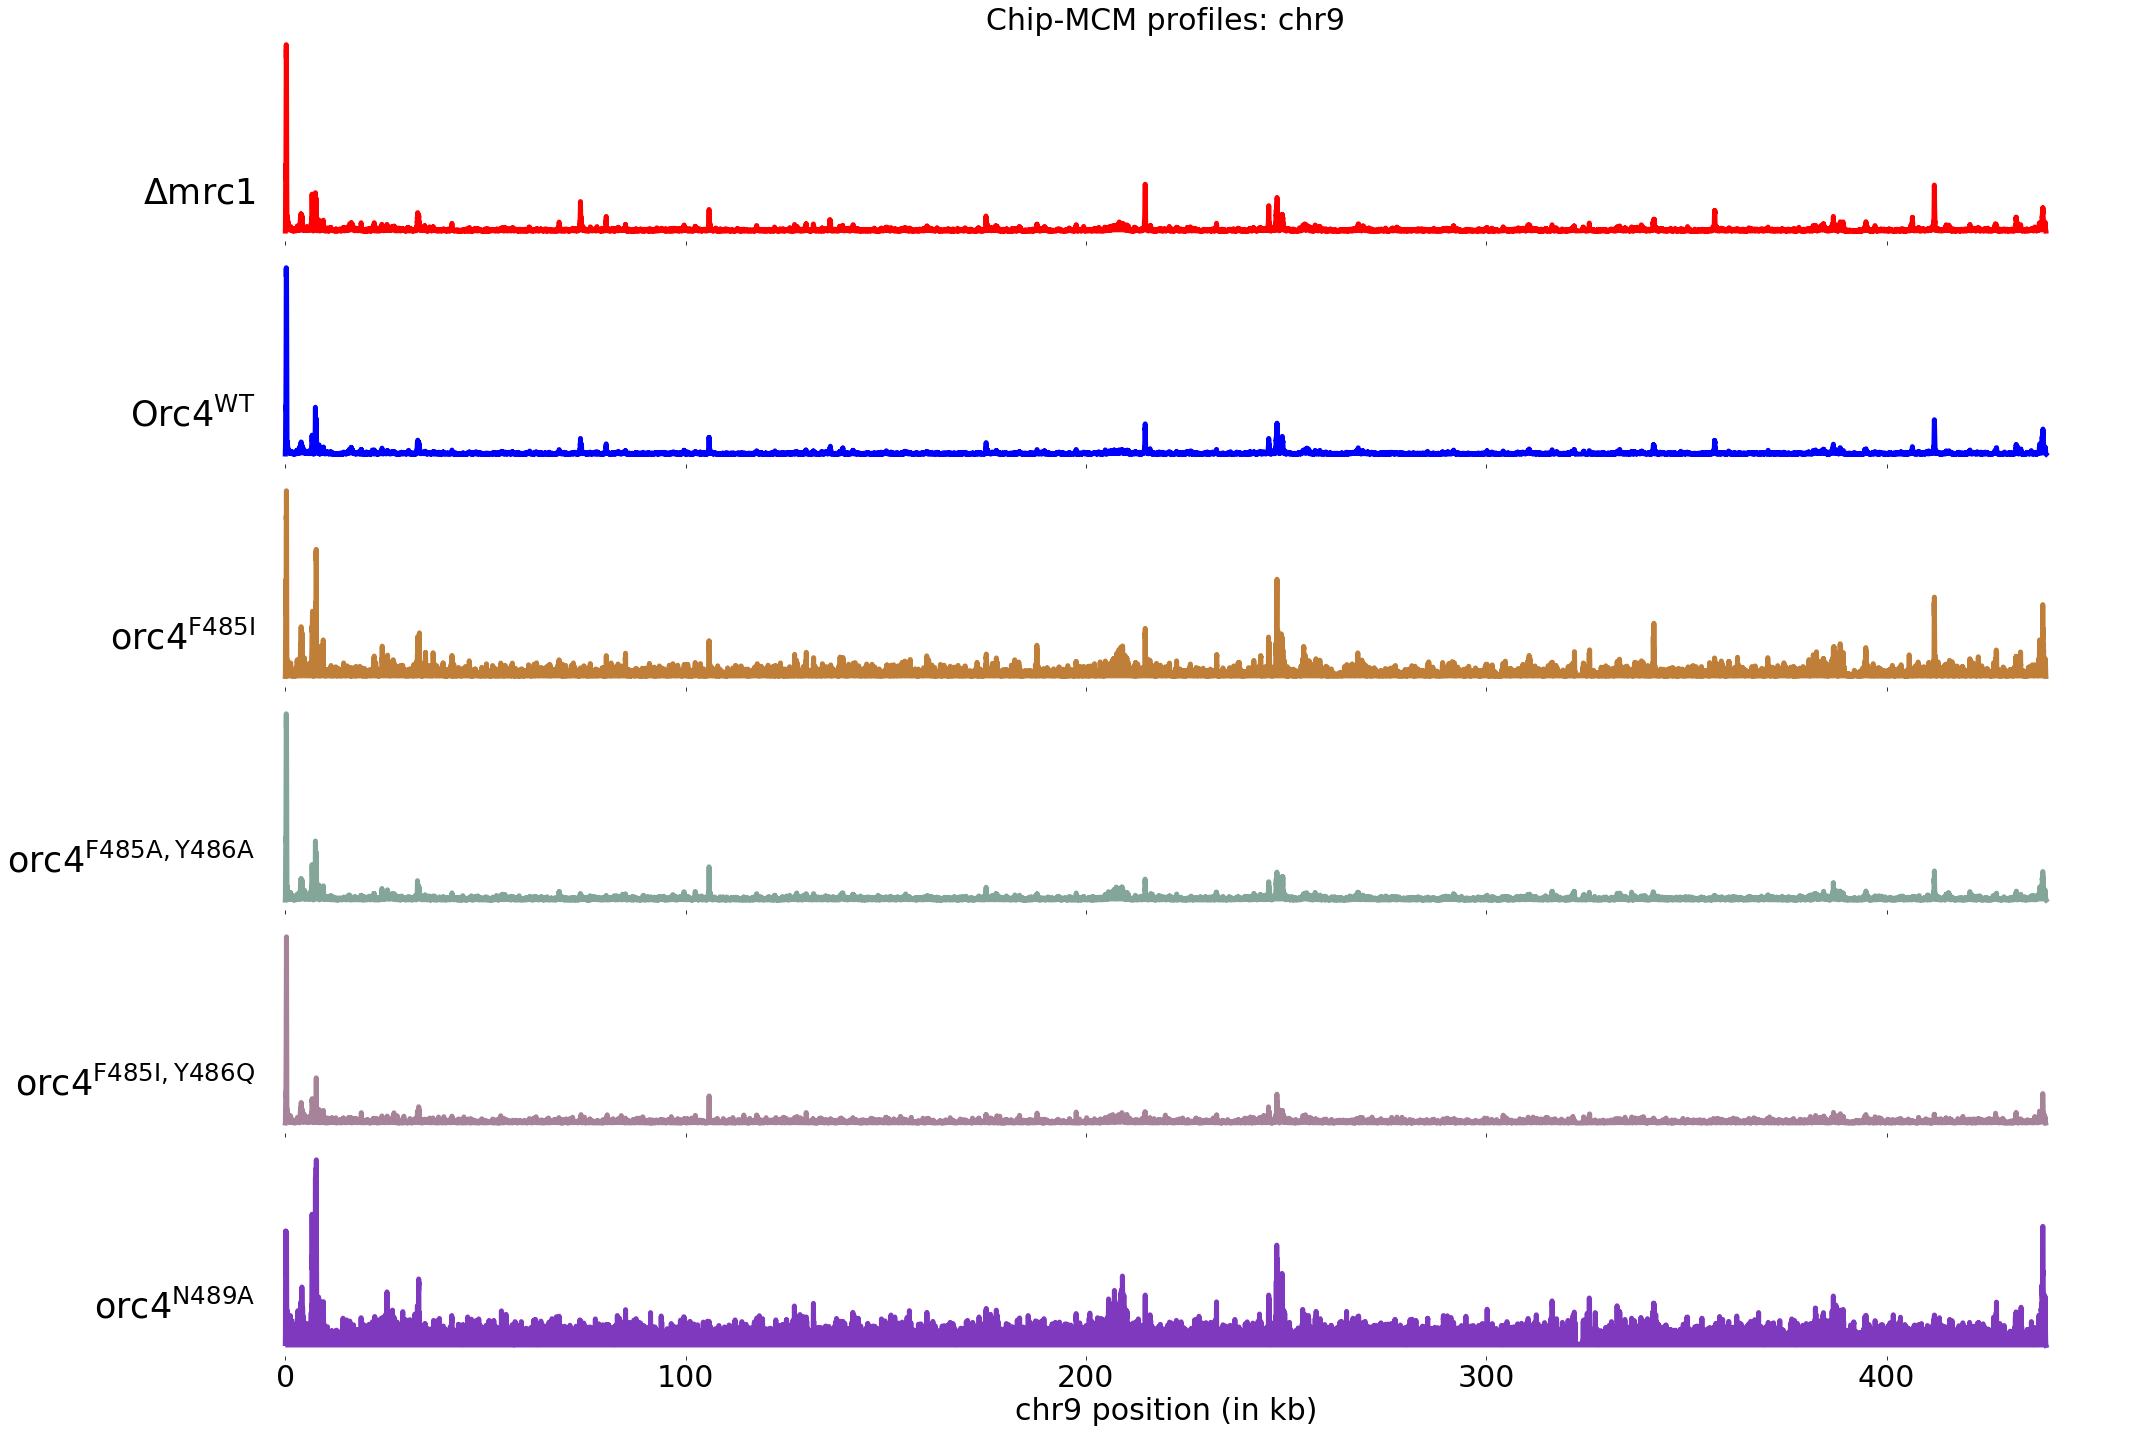

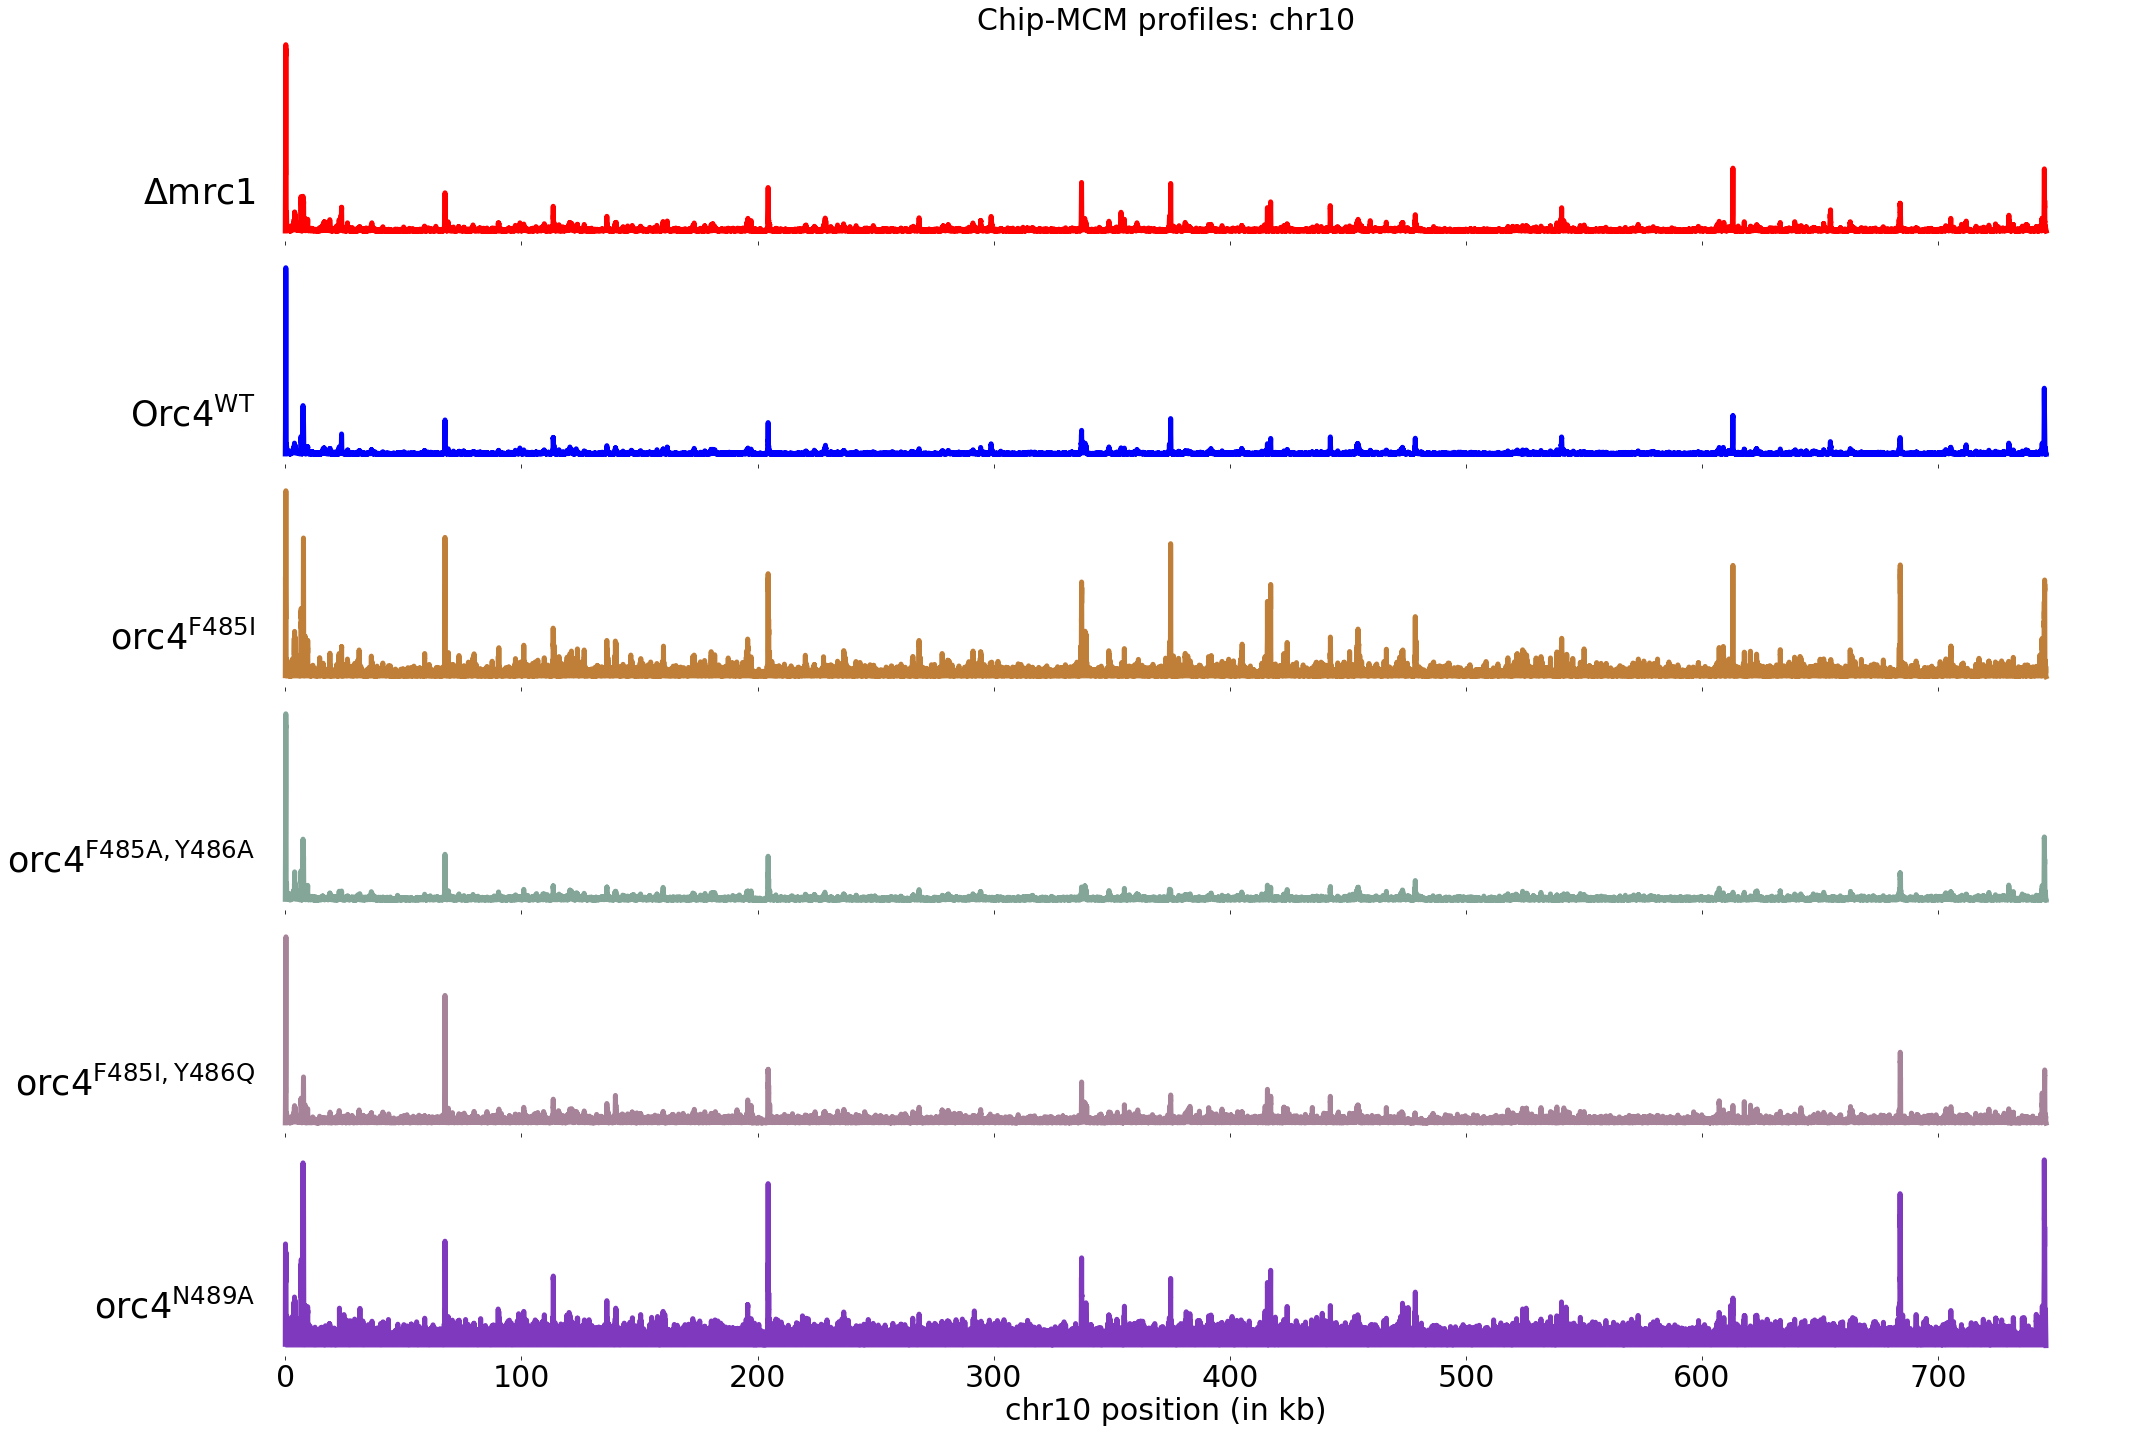

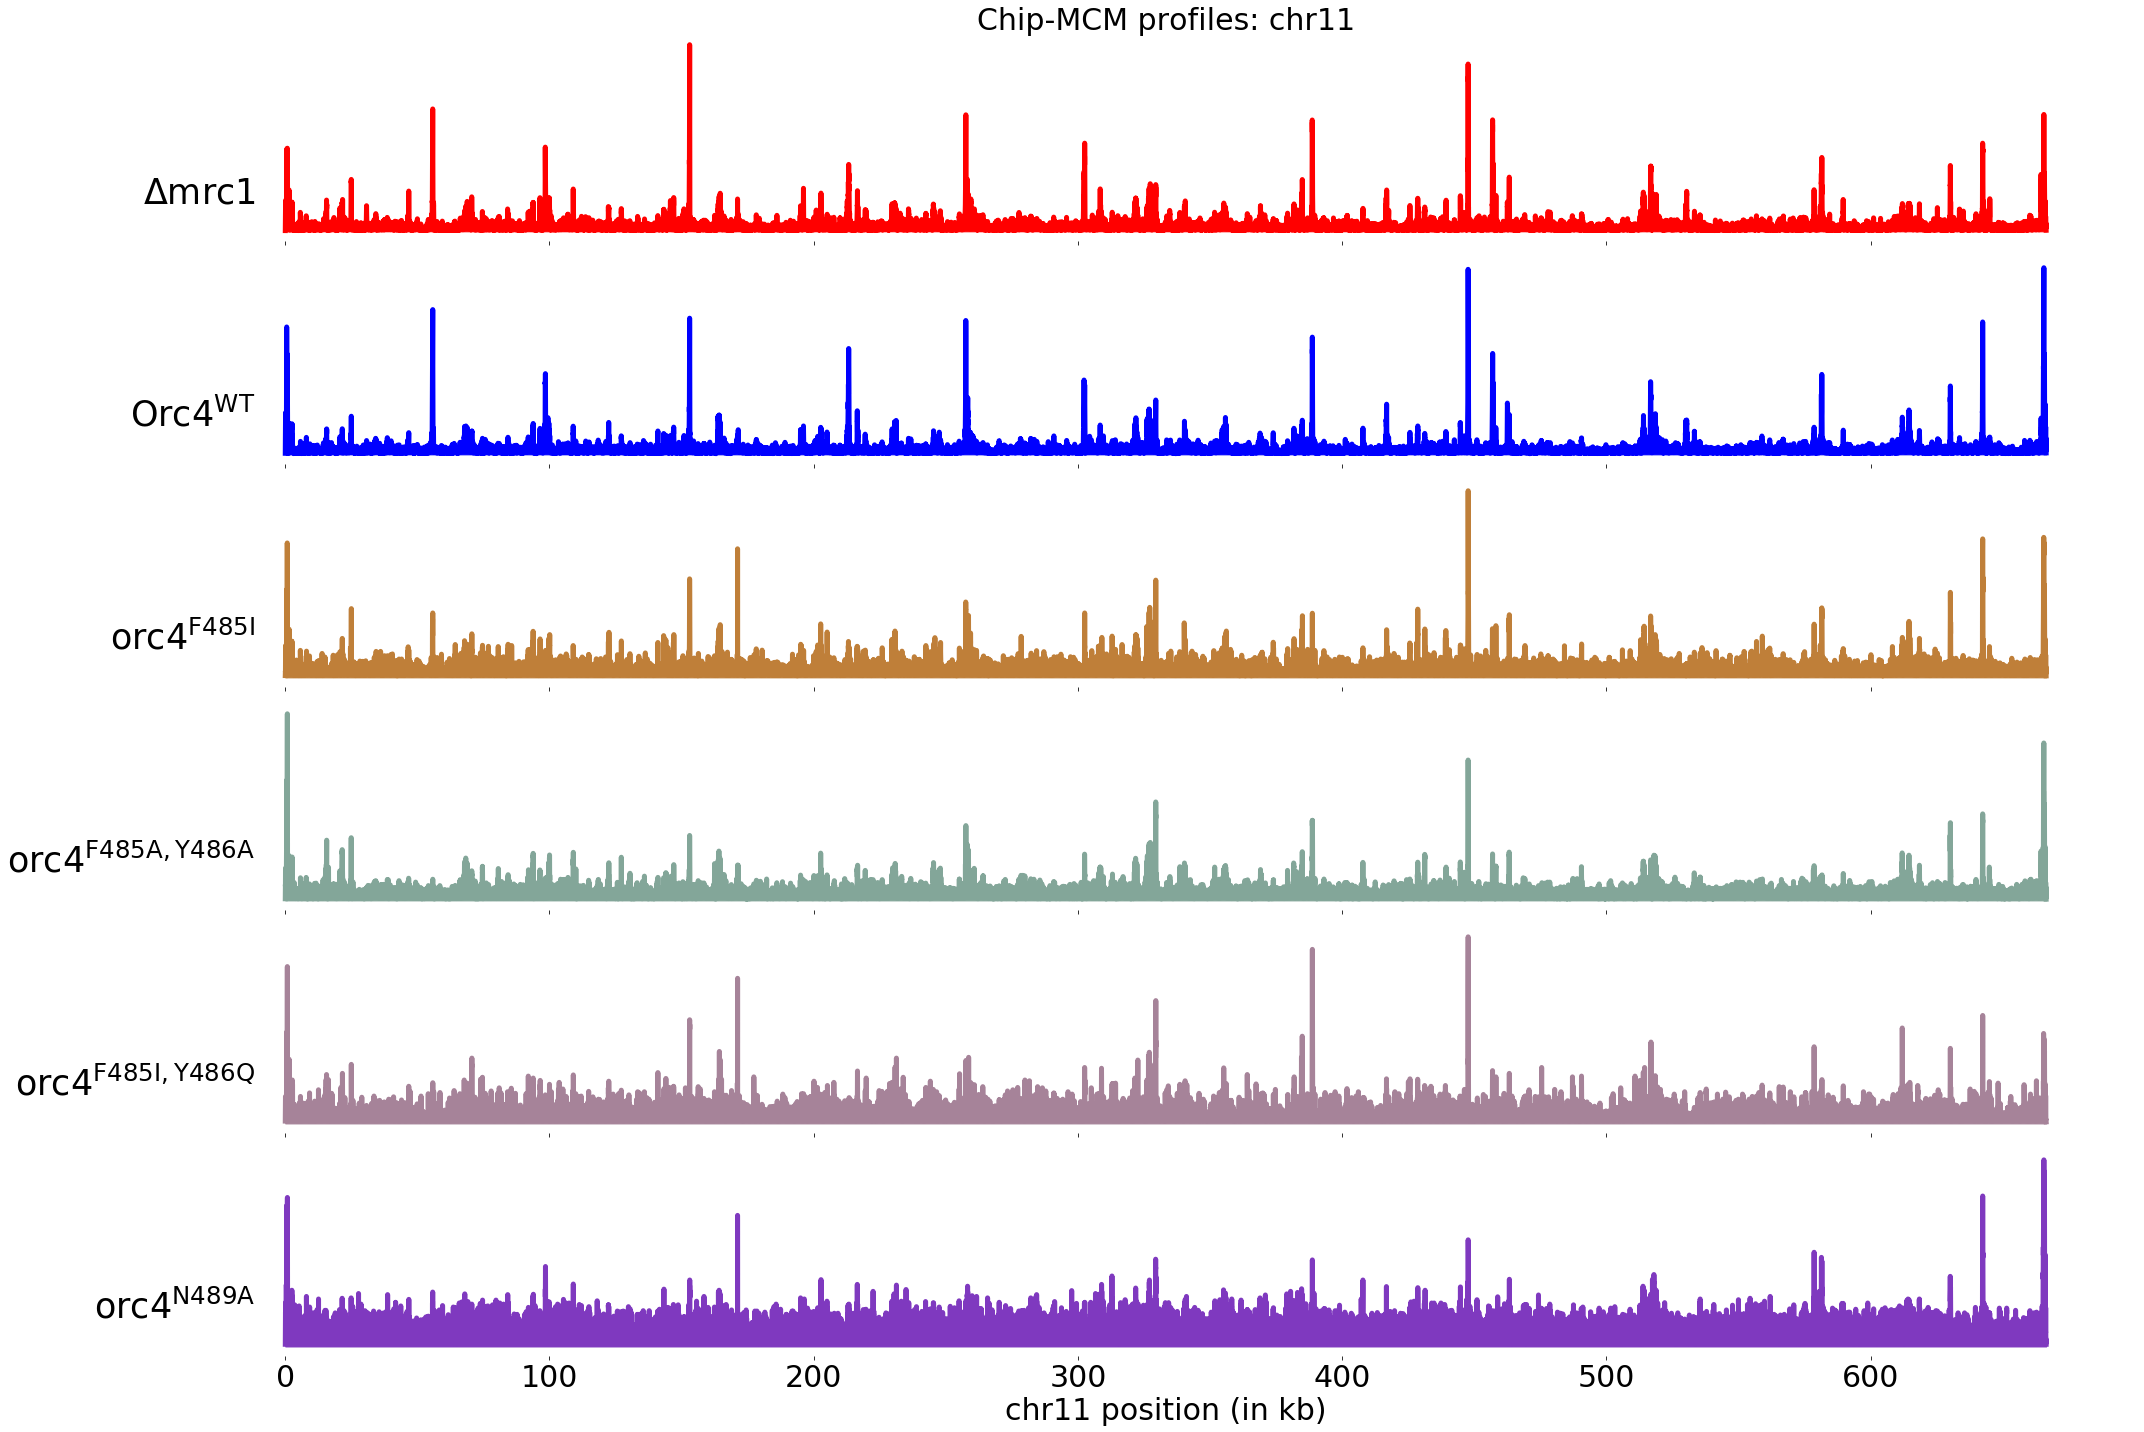

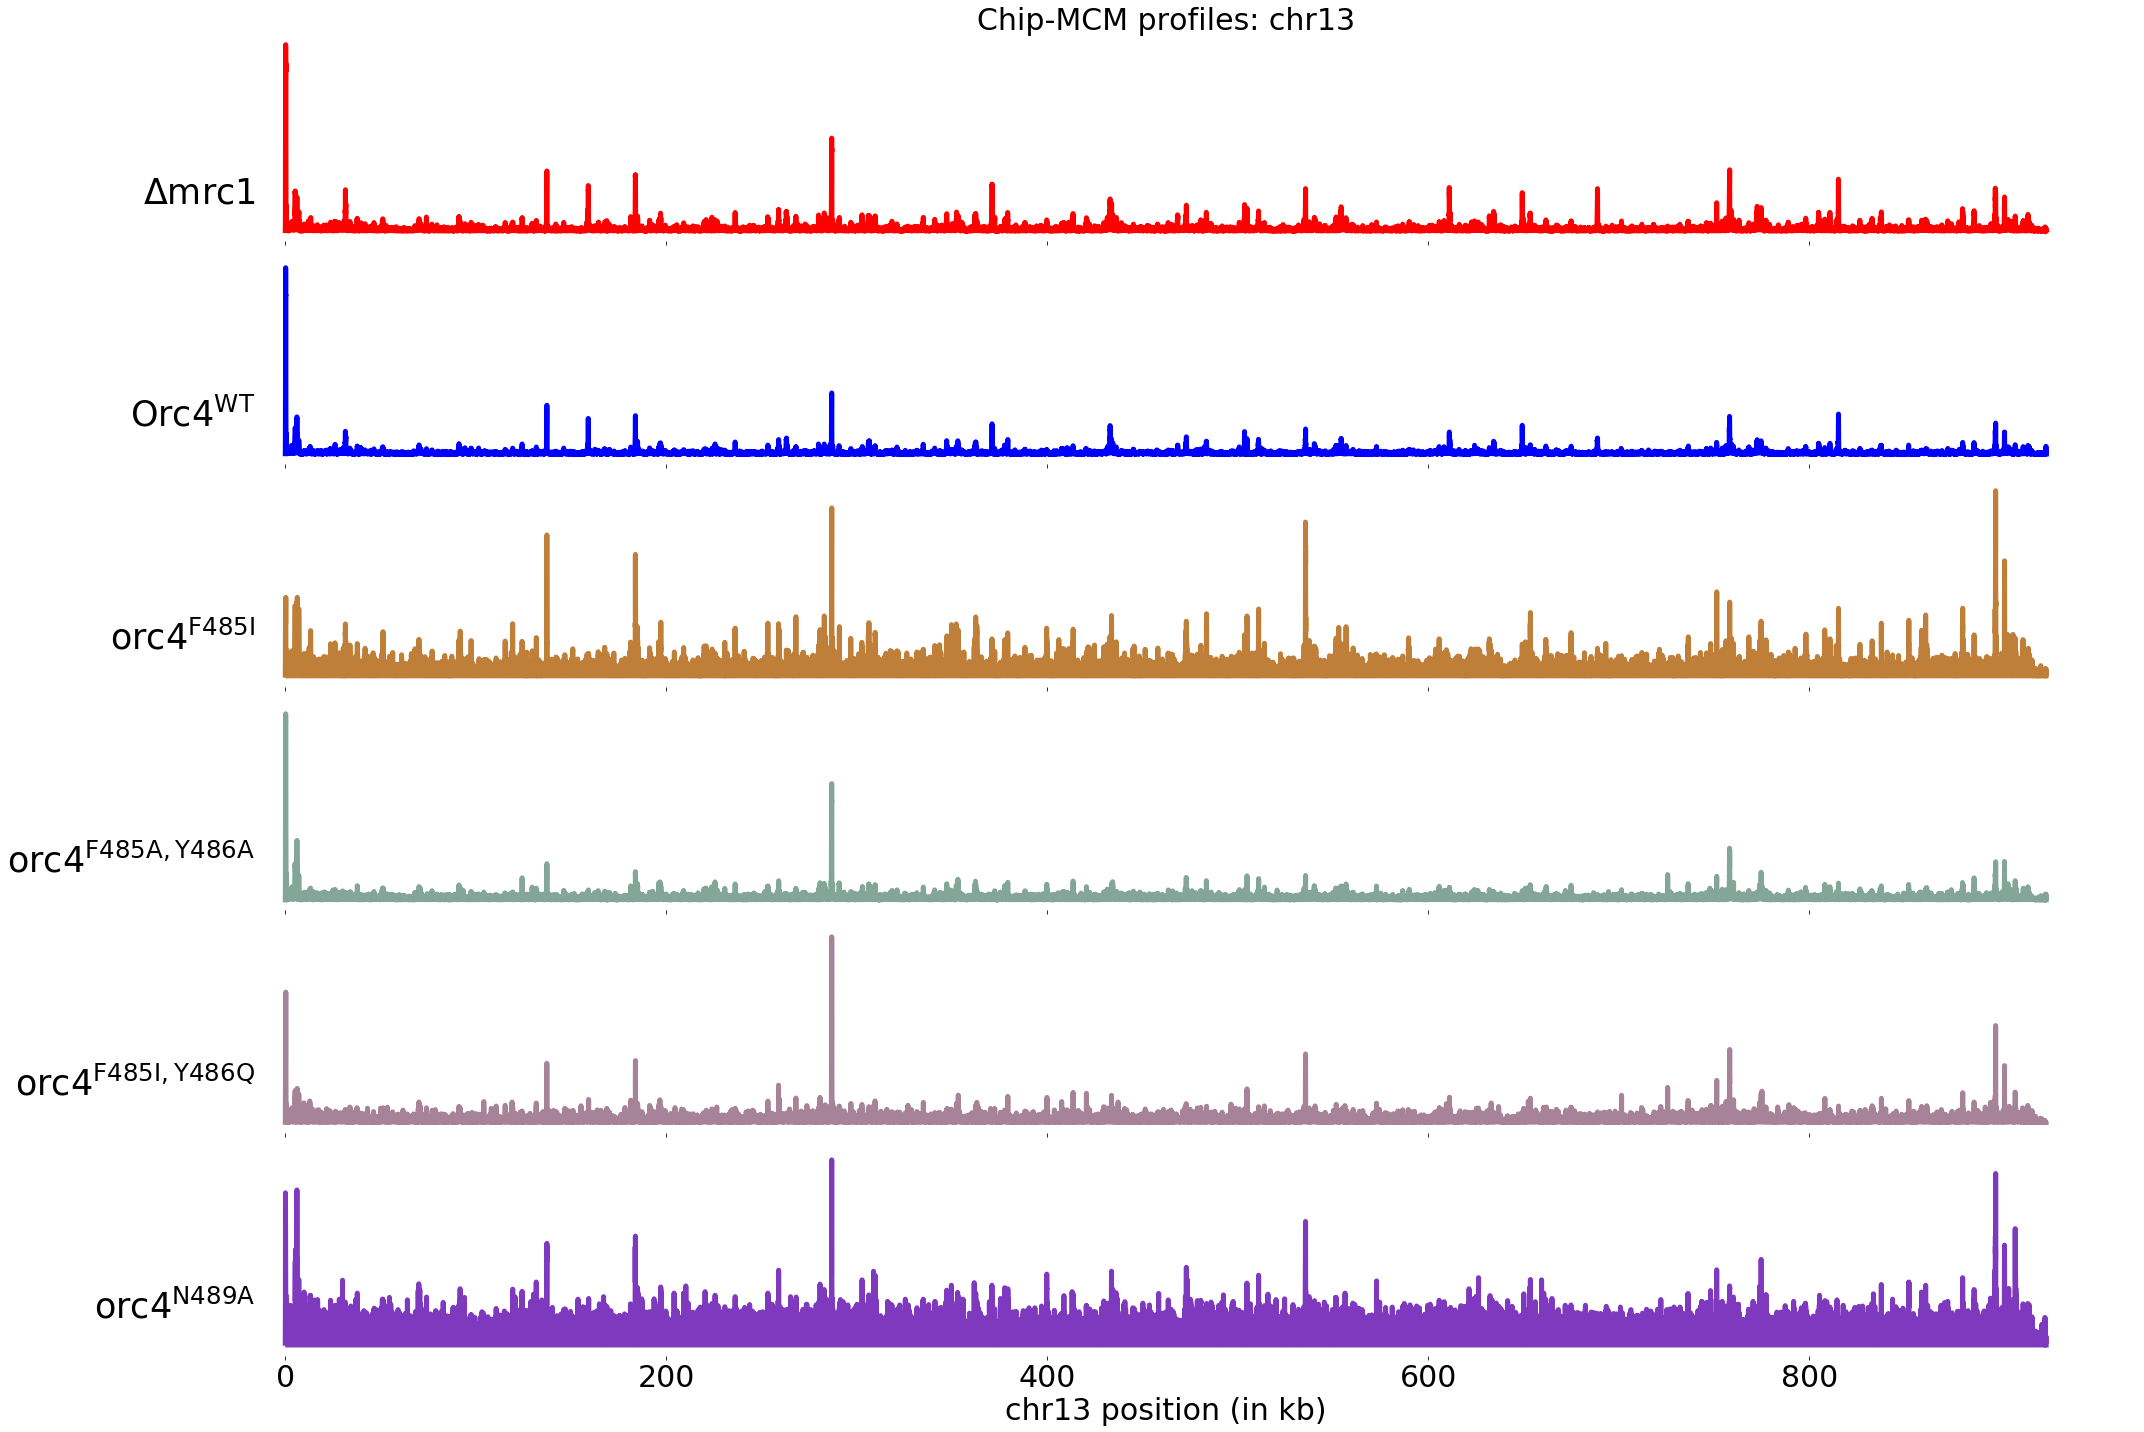

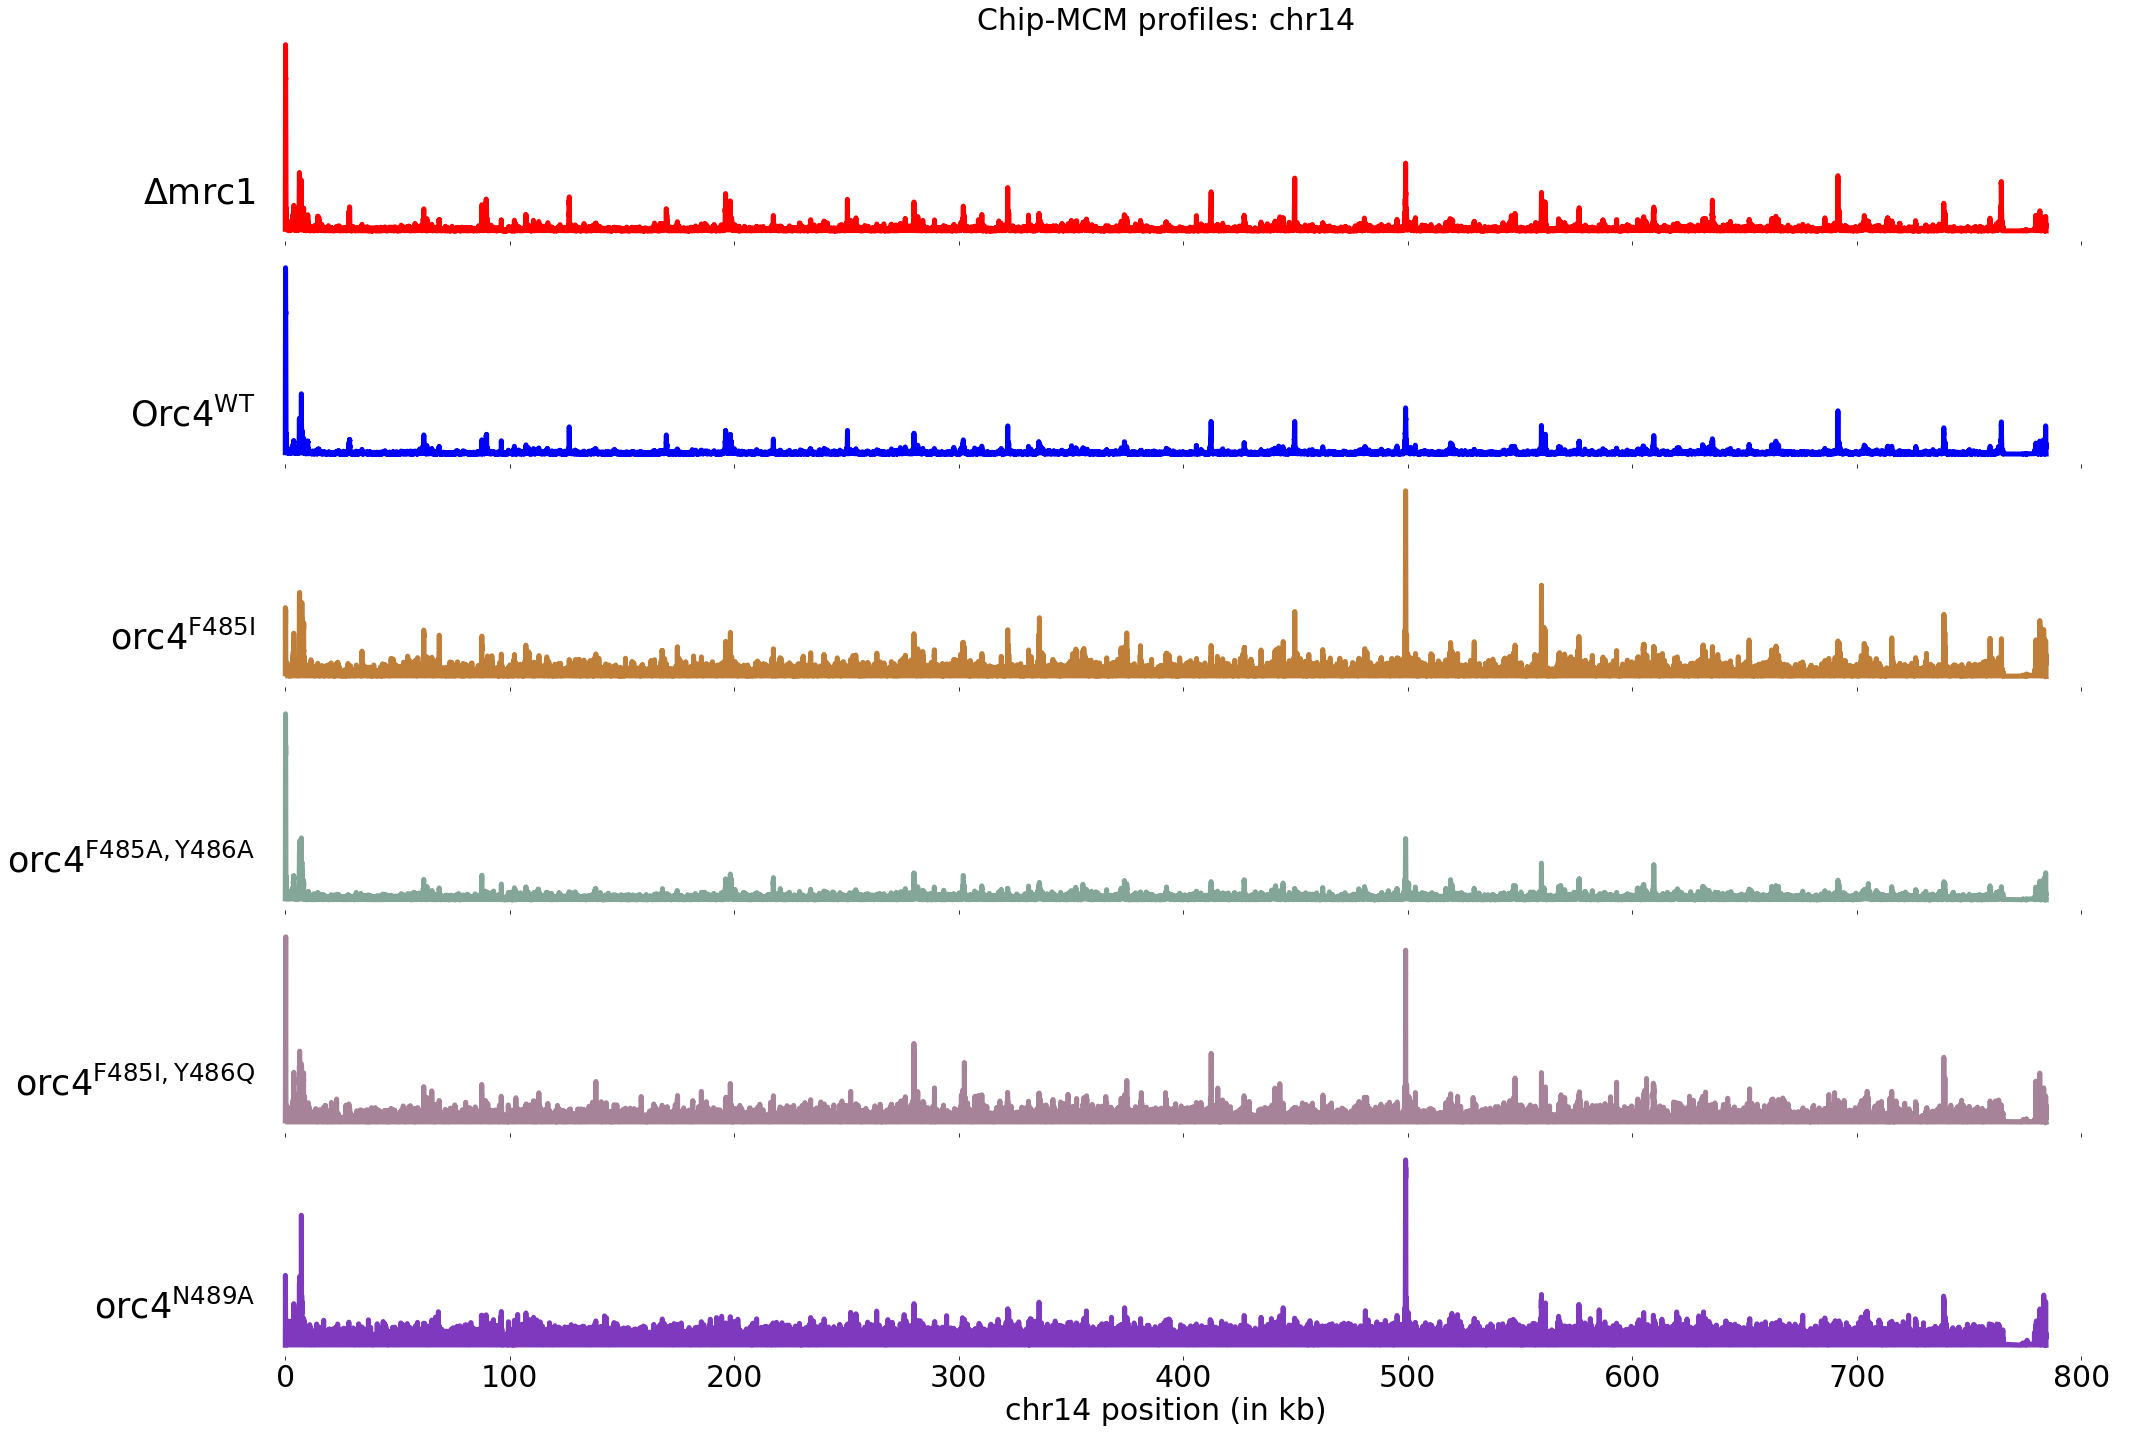

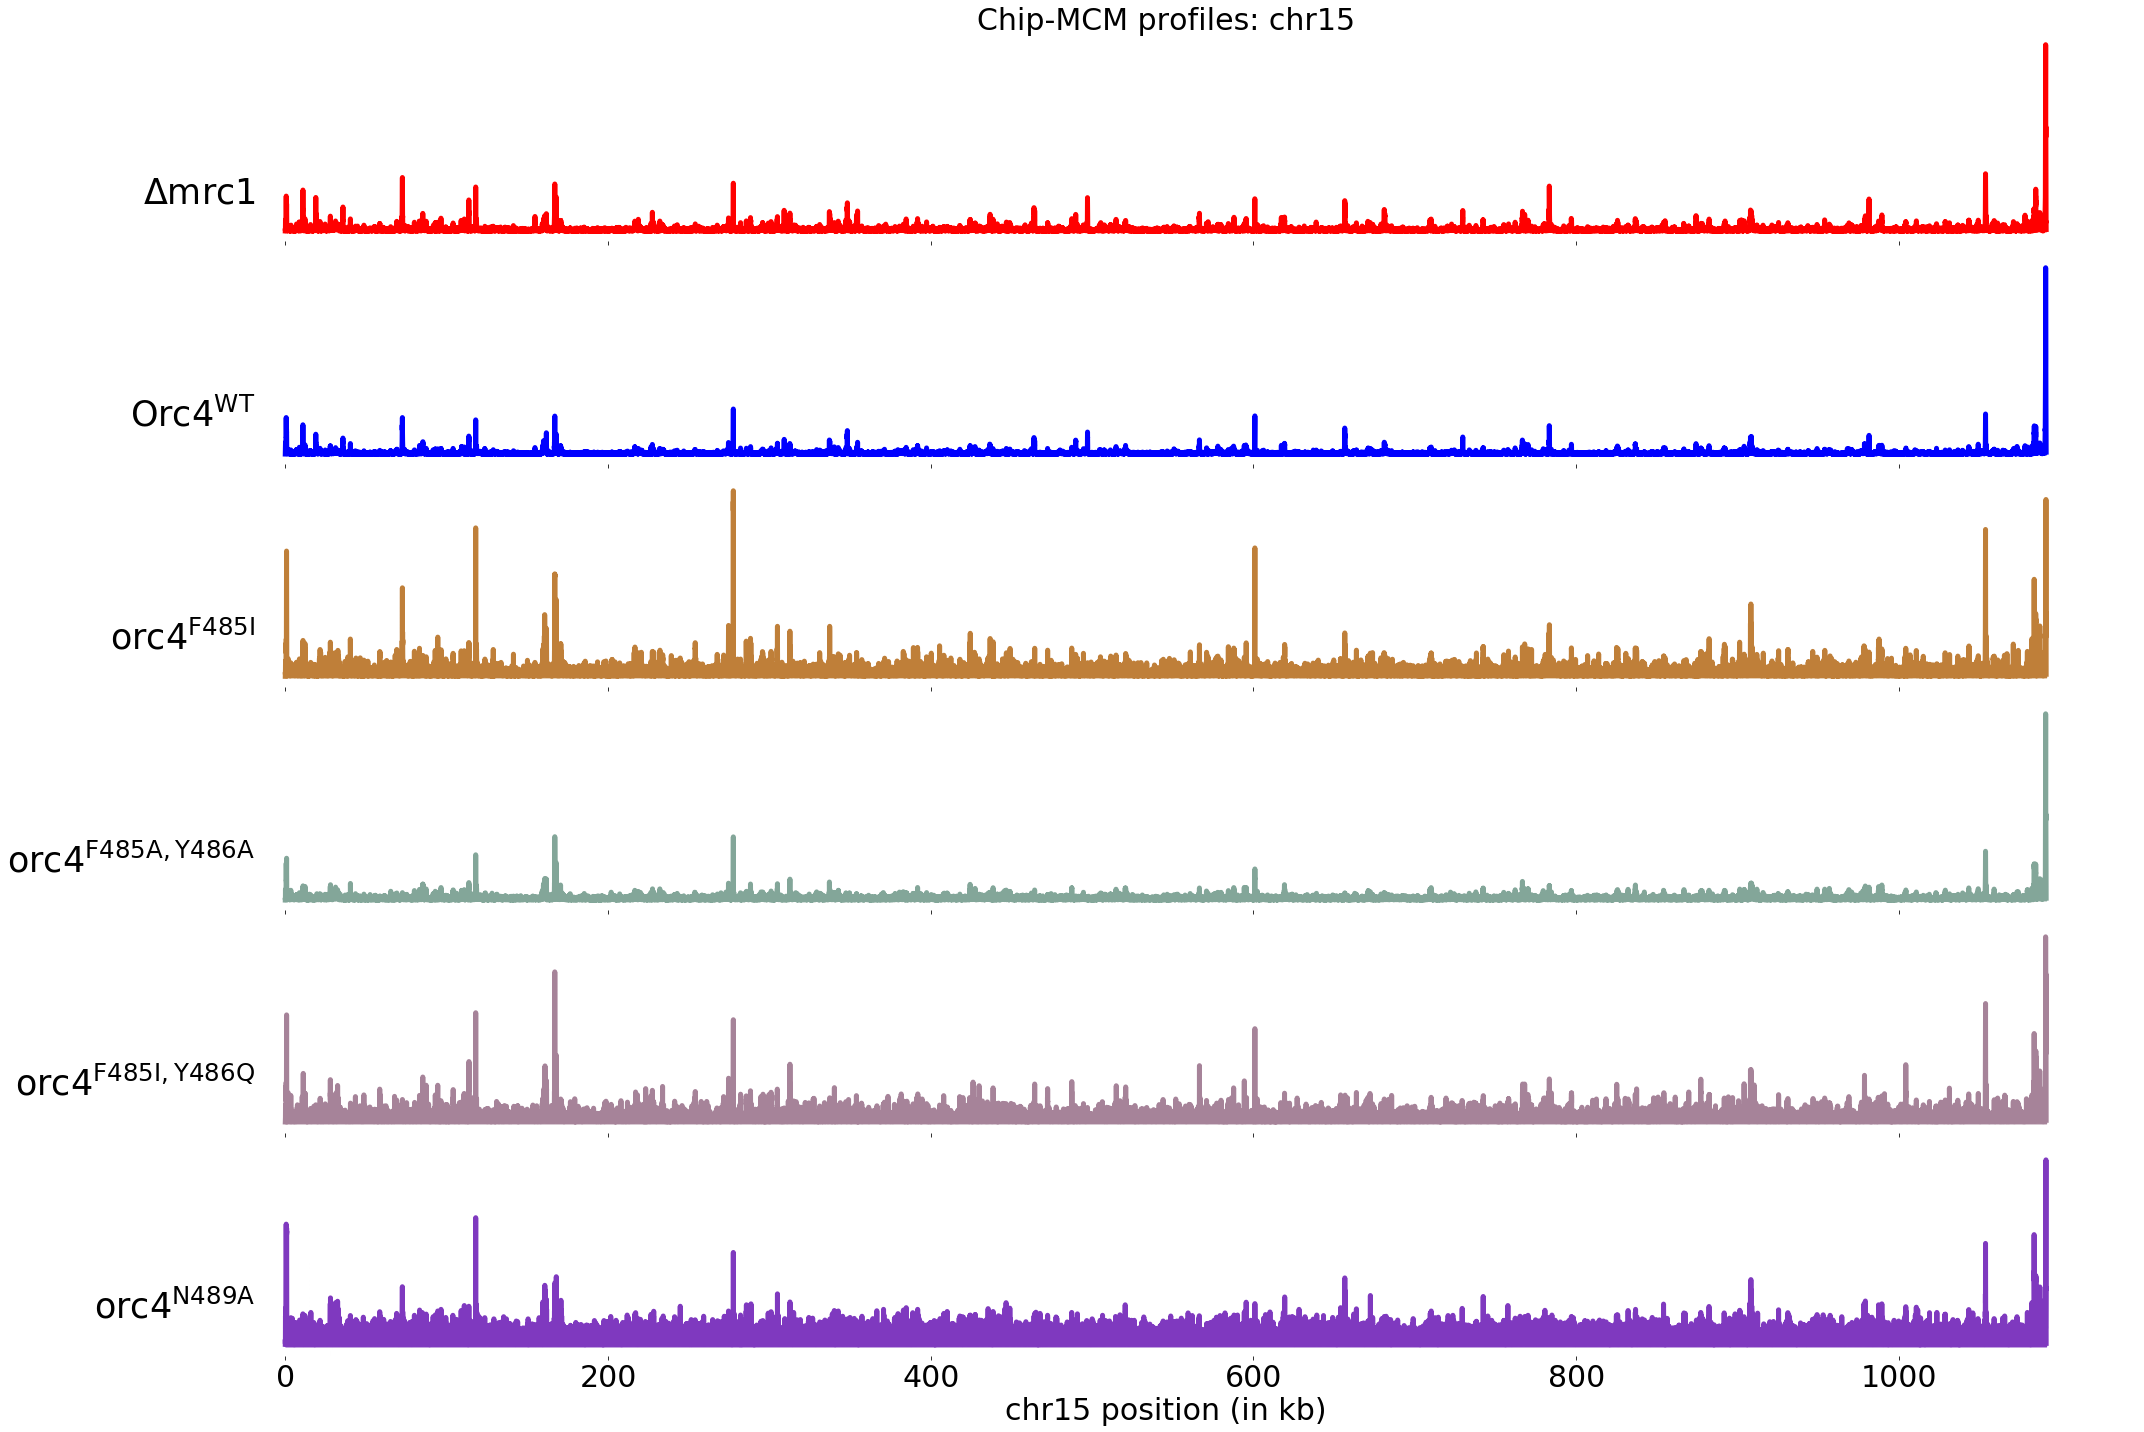

In [10]:


import pickle
import matplotlib.patches as mpatches

y_x_data = [
        (mrc1D_ys_c_mcm, mrc1D_xs_c_mcm),
        (WT_ys_c_mcm, WT_xs_c_mcm),
        (F485I_ys_c_mcm, F485I_xs_c_mcm),
        (F485A_Y486A_ys_c_mcm,F485A_Y486A_xs_c_mcm),
        (F485I_Y486Q_ys_c_mcm, F485I_Y486Q_xs_c_mcm),
        (N489A_ys_c_mcm, N489A_xs_c_mcm),
        ]


y_labels = [r'$\Delta$mrc1'
            ,r'$\mathregular{Orc4}^{\mathregular{WT}}$'
            ,r'$\mathregular{orc4}^{\mathregular{F485I}}$'
            ,r'$\mathregular{orc4}^{\mathregular{F485A,Y486A}}$'
            ,r'$\mathregular{orc4}^{\mathregular{F485I,Y486Q}}$'
            ,r'$\mathregular{orc4}^{\mathregular{N489A}}$'
            ]

#y_labels = [r'$\Delta$mrc1','WT','F485I','N489A','FA_YA','FI_YQ']

# randomly generated
colors_list = [ 
                [1.0, 0.0, 0.0],   # mrc1
                [0.0, 0.0, 1.0],   # WT
                [0.74880388, 0.49850701, 0.22479665], # F485I                
                [0.51313824, 0.65039718, 0.60103895], # FA_YA
                [0.65039718, 0.51313824, 0.60103895], # FI_YQ
                [0.49850701, 0.22479665, 0.74880388], # N489A
              ]      


for current_chromosome in chrX_list:
#for current_chromosome in ['chr4']:

    chromosome_to_plot = current_chromosome    
    np.random.seed(10)
    ars_names_list_conrad = Nieduszynski_df_c_mcm.loc[Nieduszynski_df_c_mcm['chromosome'] == chromosome_to_plot]['name'].tolist()
    ars_position_list_conrad = Nieduszynski_df_c_mcm.loc[Nieduszynski_df_c_mcm['chromosome'] == chromosome_to_plot]['position'].tolist()


    f1, axarr_e = plt.subplots(len(y_labels), sharex=True,figsize=(30,20))
    #f, axarr = plt.subplots(len(y_labels), sharex=True,figsize=(4.72441,4.72441))
    #axarr_e[0].set_title('ChIP-ORC: '+chromosome_to_plot,fontsize=25)

    plot_index = 0
    for y_data,x_data in y_x_data:
        
        axarr_e[plot_index].plot(x_data[chromosome_to_plot], y_data[chromosome_to_plot]/percentile_across_genome(y_data),linewidth=5,color=colors_list[plot_index])
        axarr_e[plot_index].set_ylabel(y_labels[plot_index],fontsize=35, rotation=0, labelpad=0,horizontalalignment='right')
        #axarr_e[plot_index].tick_params(axis='y', which='major', labelsize=30)
        axarr_e[plot_index].fill_between(x_data[chromosome_to_plot], y_data[chromosome_to_plot]/percentile_across_genome(y_data),color=colors_list[plot_index])


        # remove spines
        axarr_e[plot_index].spines['right'].set_visible(False)
        axarr_e[plot_index].spines['top'].set_visible(False)
        axarr_e[plot_index].spines['bottom'].set_visible(False)
        axarr_e[plot_index].spines['left'].set_visible(False)
        
     

        # remove y-ticks
        axarr_e[plot_index].set_yticks([])

        if plot_index==0:
                axarr_e[0].set_title('Chip-MCM profiles: '+chromosome_to_plot,fontsize=30)

        axarr_e[plot_index].yaxis.set_label_coords(0.03, 0.15)
        plot_index +=1

        
    # edu exp 2 values
    max_height_of_vlines = 12.25

    labels = ['OridB ARS']

    #Mrc1_peaks_label = mpatches.Patch(color='red')
    #f.legend(handles=[WT, M22, oridb,Mrc1_peaks], labels=labels, loc="right",fontsize='xx-large')
    #f1.legend(handles=[oridb], labels=labels, loc="right",fontsize='xx-large')

    axarr_e[plot_index-1].tick_params(axis='x', which='major', labelsize=30)  
    axarr_e[plot_index-1].set_xlabel(chromosome_to_plot + ' position (in kb)', fontsize=30)
    f1.subplots_adjust(hspace=0.25)


    plt.tight_layout()
    plt.savefig('mcm_profiles/Figure_2_chip_mcm_panel'+current_chromosome+'.png')

### mcm profiles - replicates

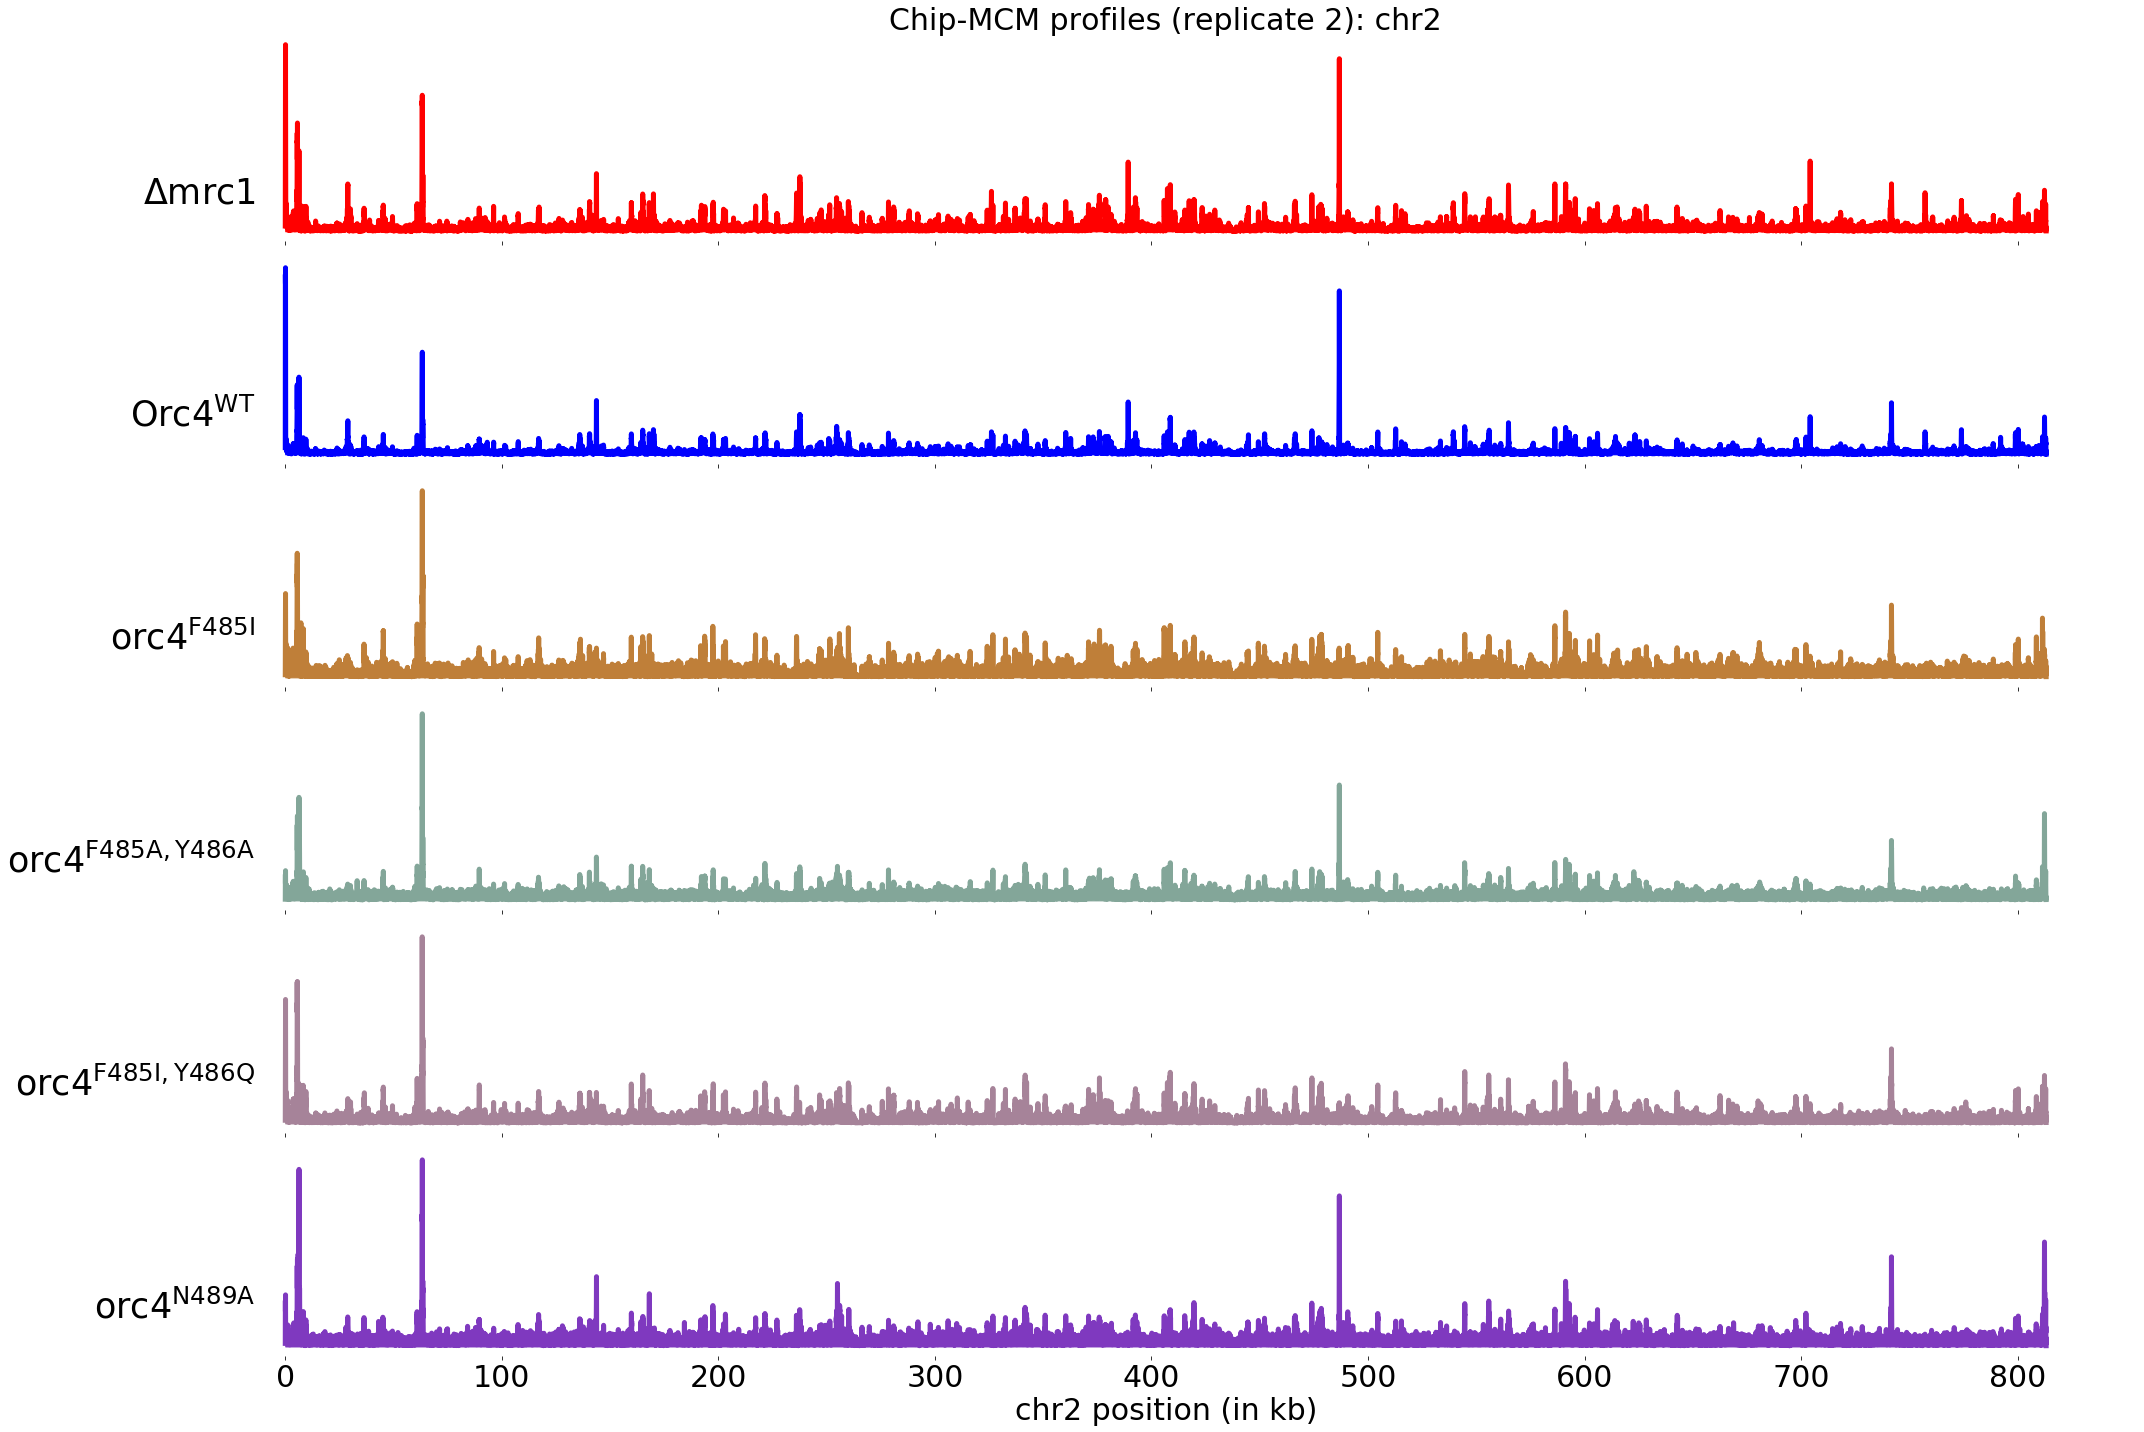

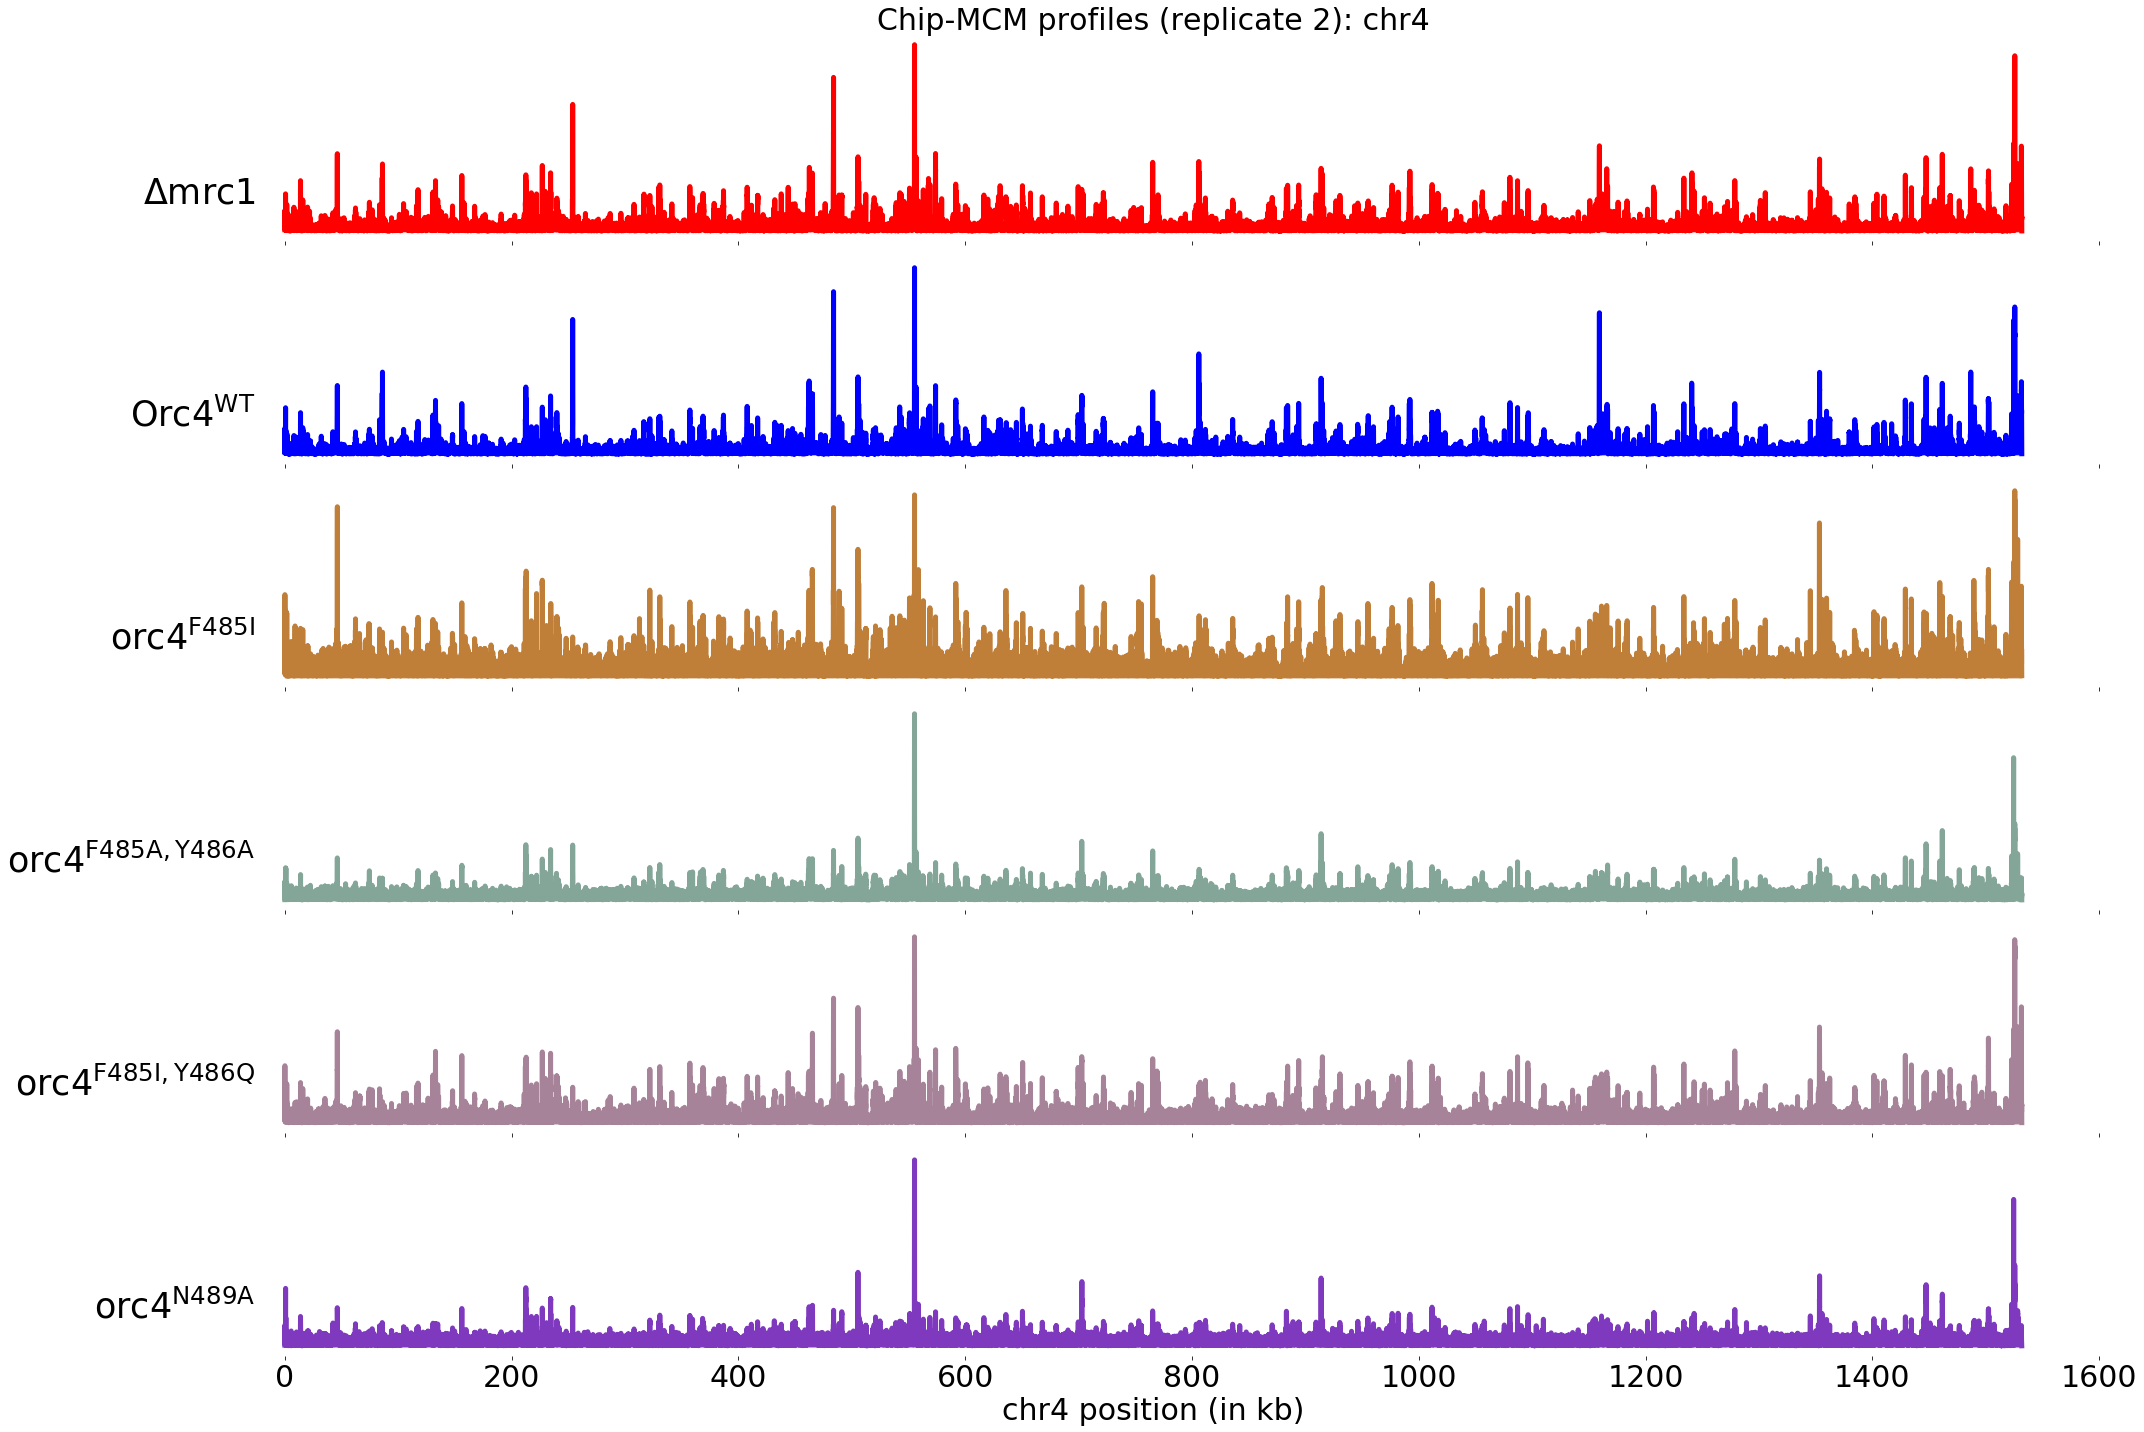

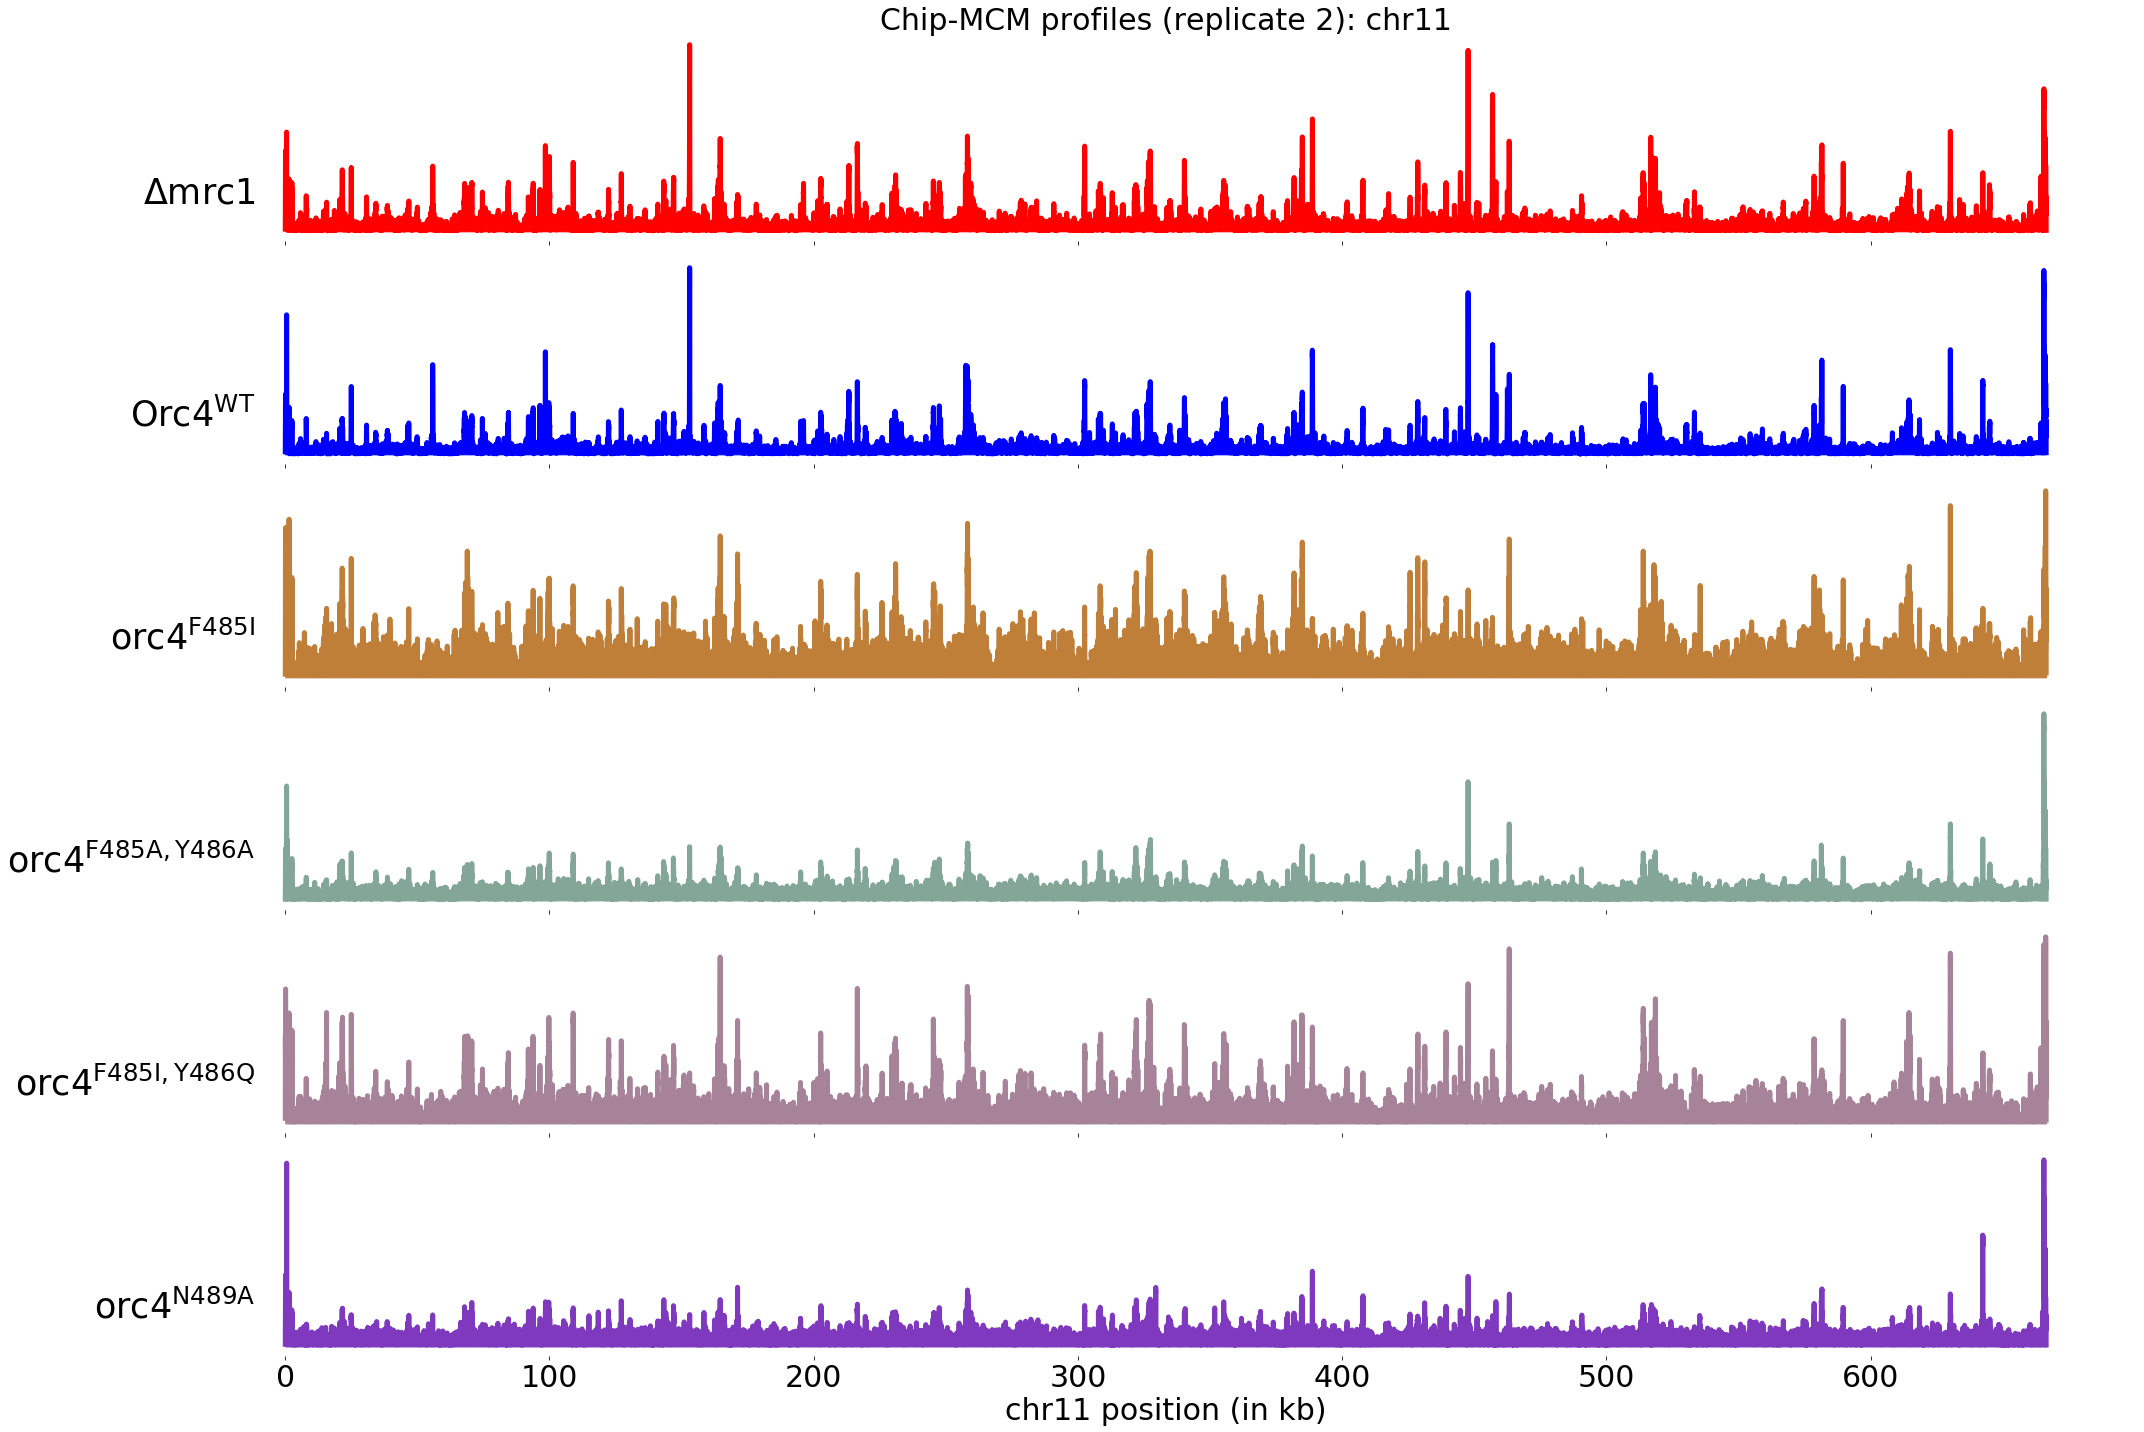

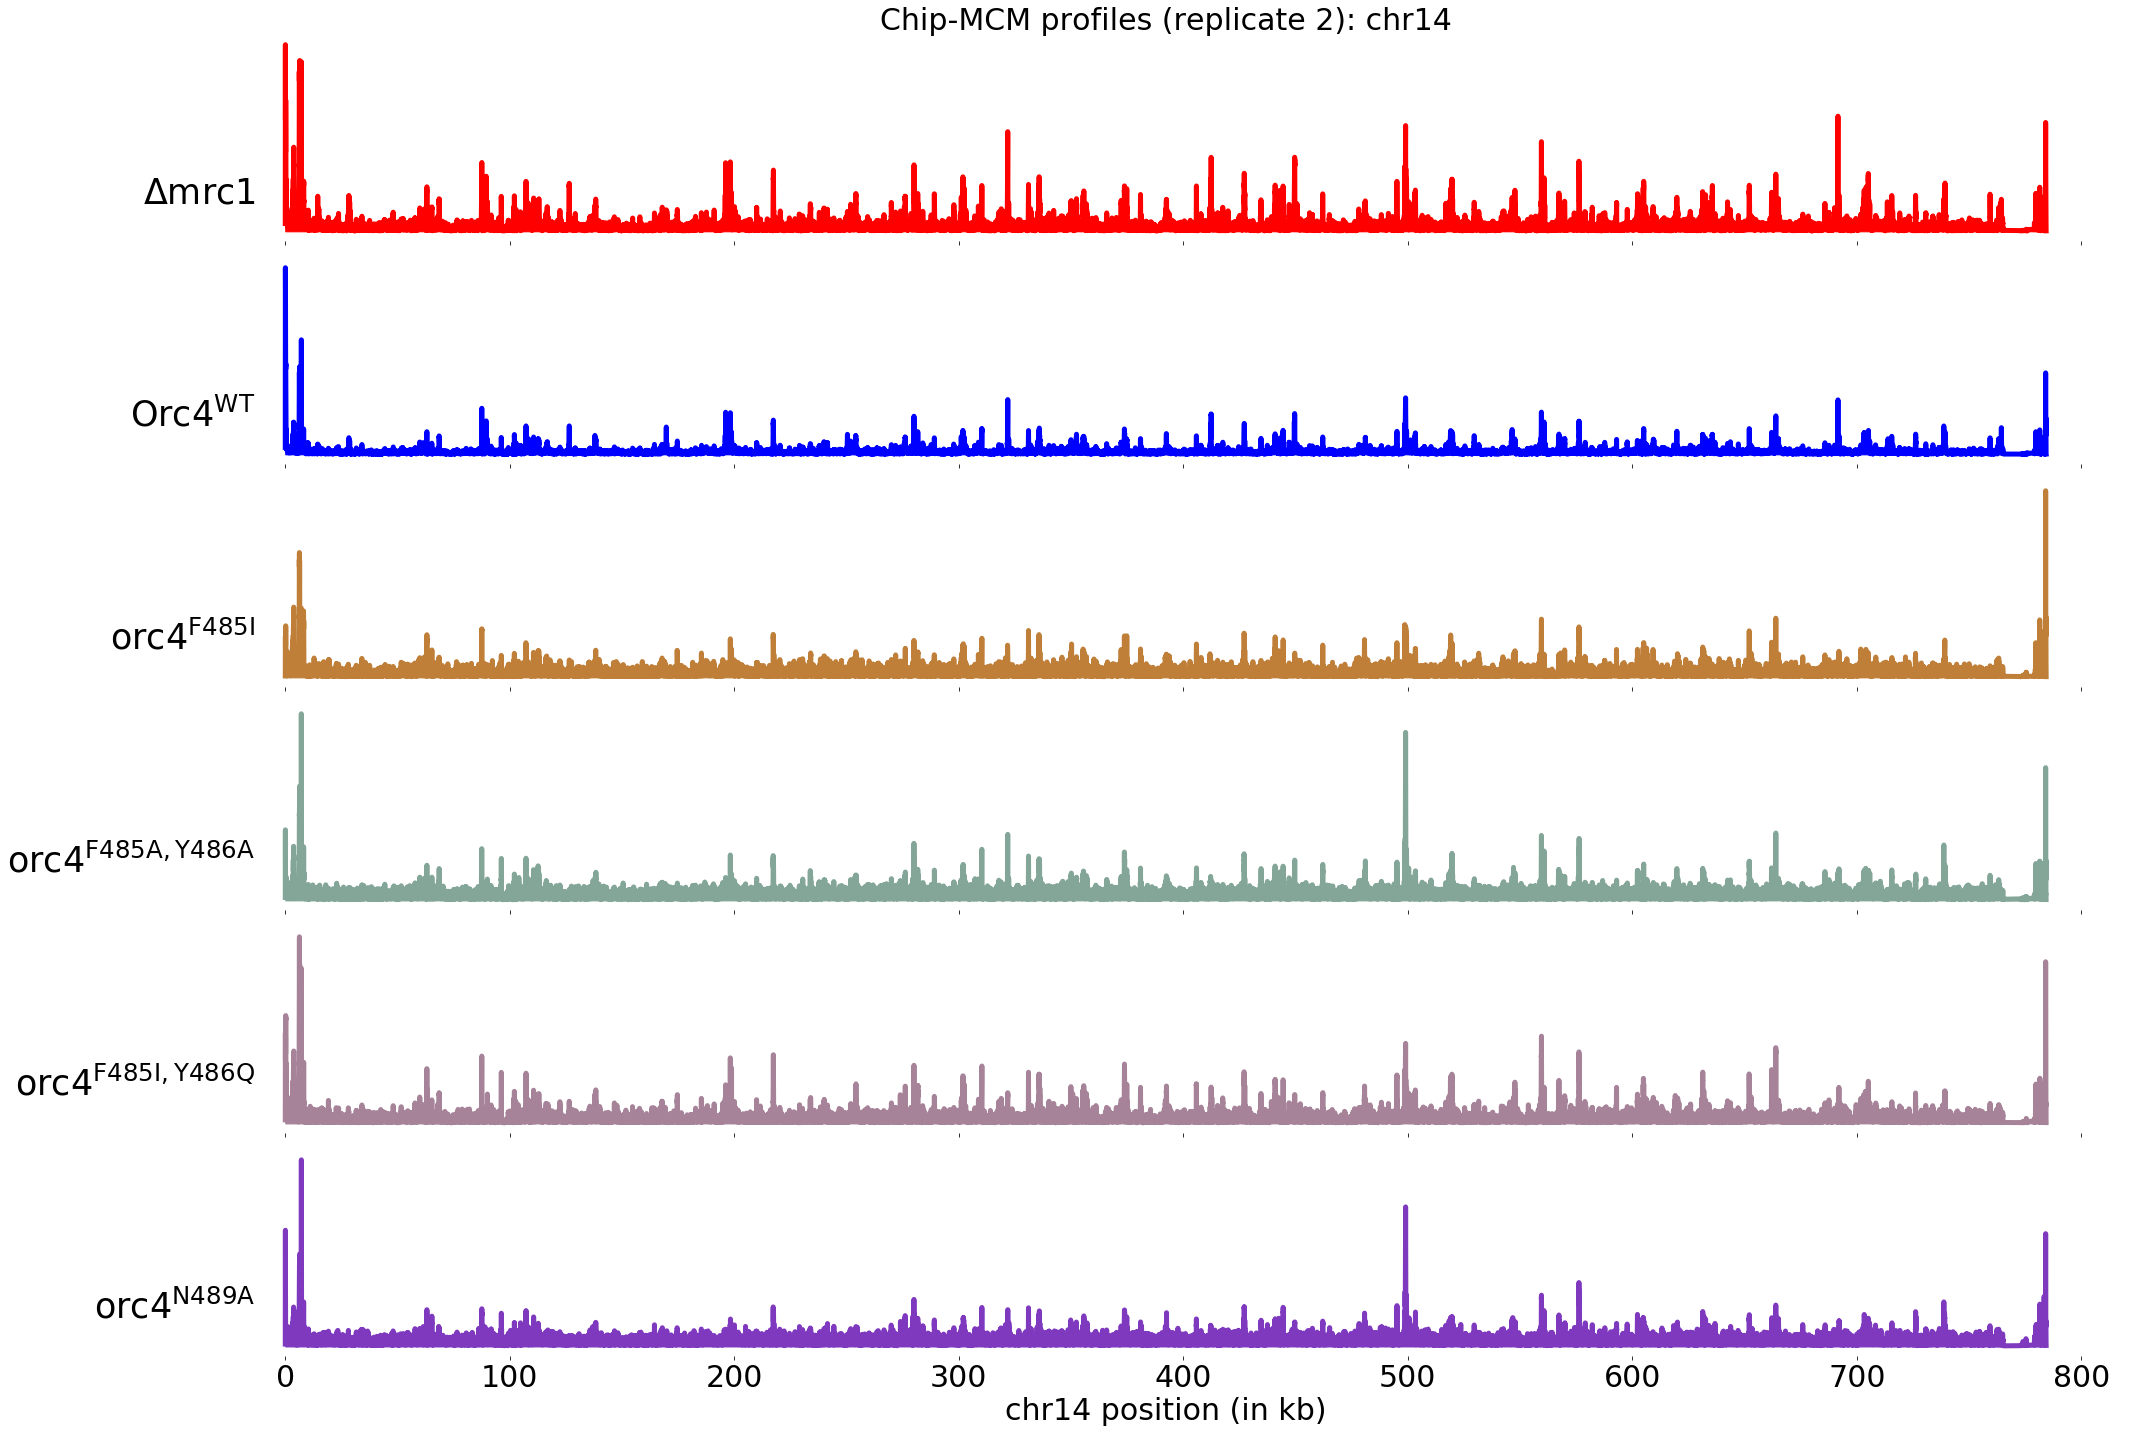

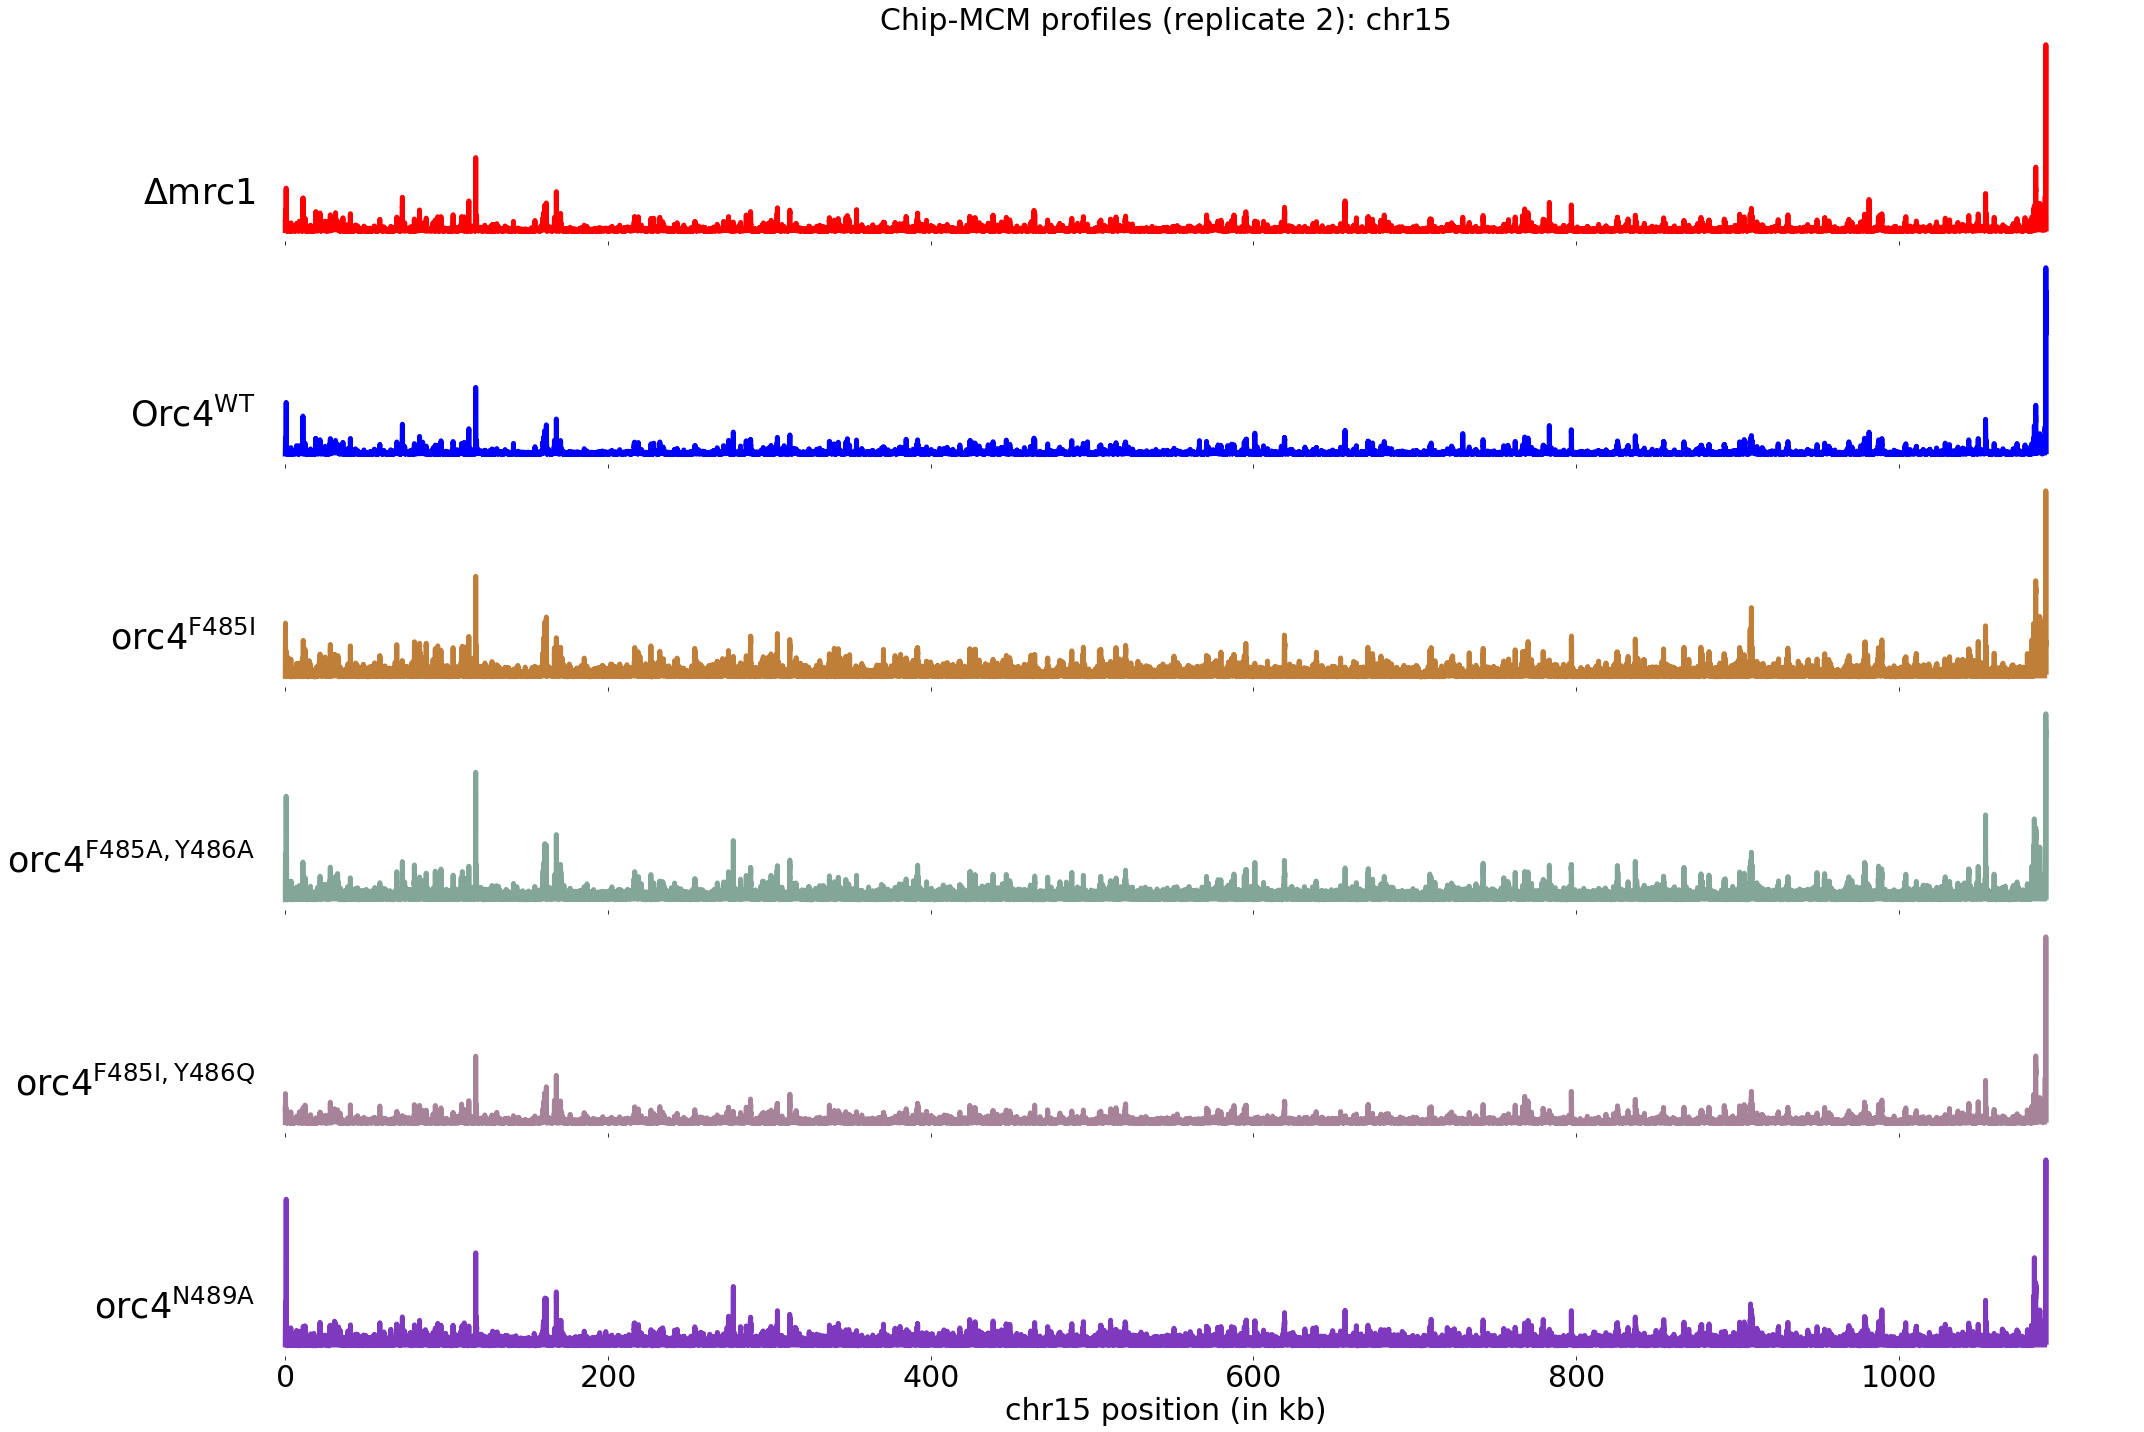

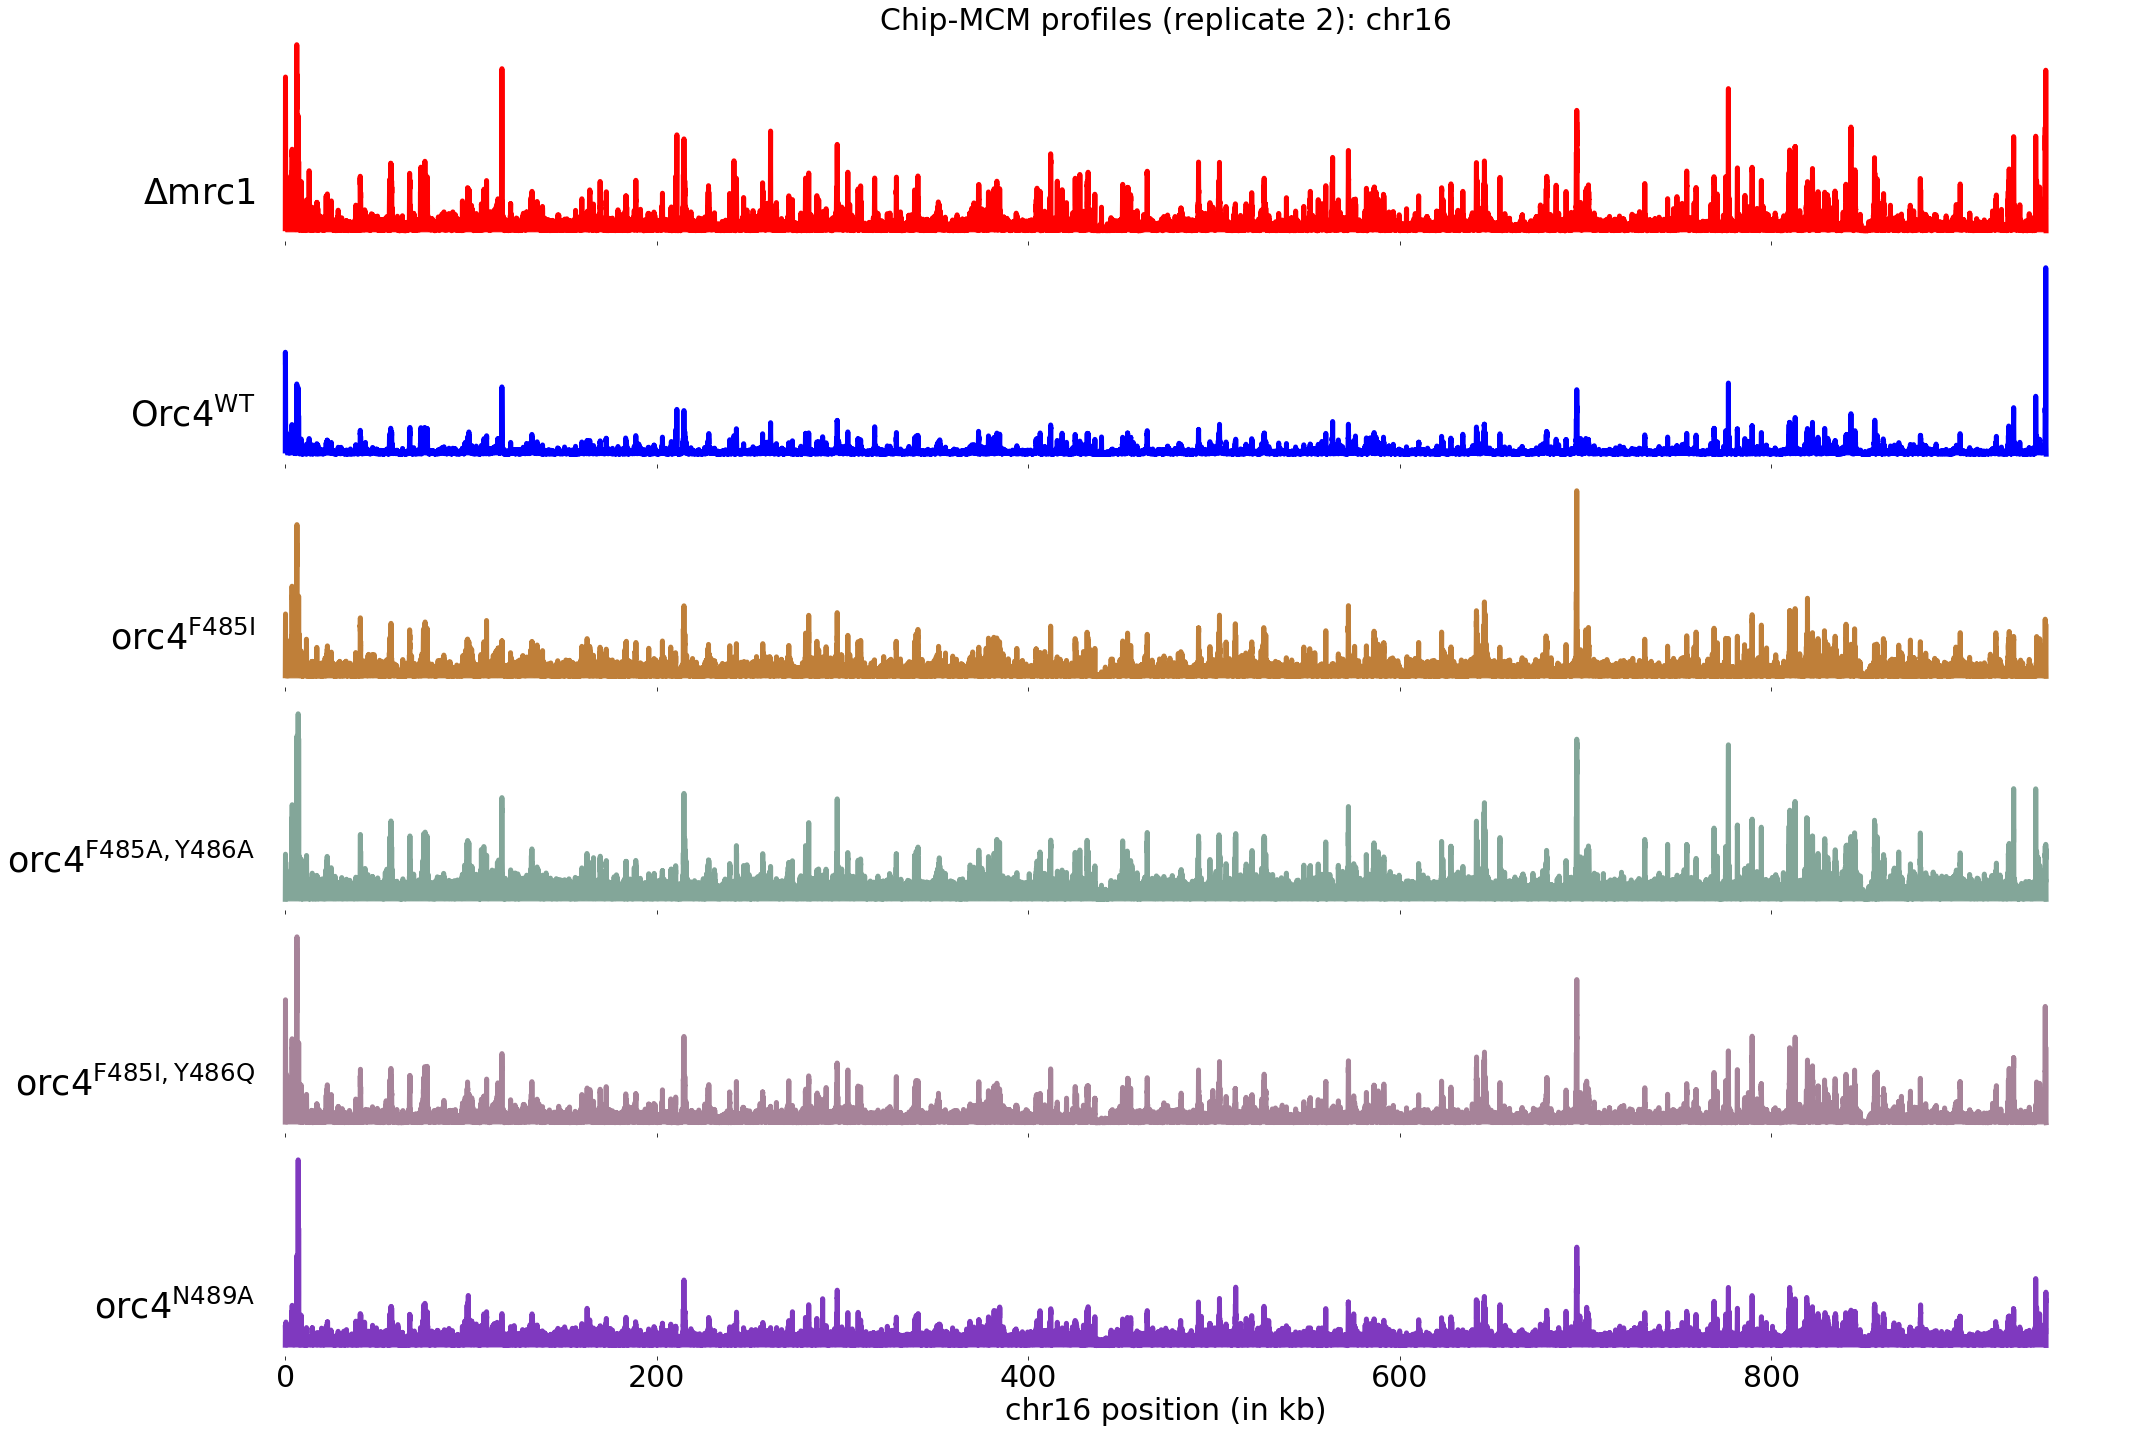

In [12]:
import pickle
import matplotlib.patches as mpatches

y_x_data = [
        (mrc1D_ys_c_mcm_rep2, mrc1D_xs_c_mcm_rep2),
        (WT_ys_c_mcm_rep2, WT_xs_c_mcm_rep2),
        (F485I_ys_c_mcm_rep2, F485I_xs_c_mcm_rep2),
        (F485A_Y486A_ys_c_mcm_rep2,F485A_Y486A_xs_c_mcm_rep2),
        (F485I_Y486Q_ys_c_mcm_rep2, F485I_Y486Q_xs_c_mcm_rep2),
        (N489A_ys_c_mcm_rep2, N489A_xs_c_mcm_rep2),
        ]


y_labels = [r'$\Delta$mrc1'
            ,r'$\mathregular{Orc4}^{\mathregular{WT}}$'
            ,r'$\mathregular{orc4}^{\mathregular{F485I}}$'
            ,r'$\mathregular{orc4}^{\mathregular{F485A,Y486A}}$'
            ,r'$\mathregular{orc4}^{\mathregular{F485I,Y486Q}}$'
            ,r'$\mathregular{orc4}^{\mathregular{N489A}}$'
            ]

#y_labels = [r'$\Delta$mrc1','WT','F485I','N489A','FA_YA','FI_YQ']

# randomly generated
colors_list = [ 
                [1.0, 0.0, 0.0],   # mrc1
                [0.0, 0.0, 1.0],   # WT
                [0.74880388, 0.49850701, 0.22479665], # F485I                
                [0.51313824, 0.65039718, 0.60103895], # FA_YA
                [0.65039718, 0.51313824, 0.60103895], # FI_YQ
                [0.49850701, 0.22479665, 0.74880388], # N489A
              ]      

for current_chromosome in chrX_list:

    chromosome_to_plot = current_chromosome    
    np.random.seed(10)
    ars_names_list_conrad = Nieduszynski_df_c_mcm.loc[Nieduszynski_df_c_mcm['chromosome'] == chromosome_to_plot]['name'].tolist()
    ars_position_list_conrad = Nieduszynski_df_c_mcm.loc[Nieduszynski_df_c_mcm['chromosome'] == chromosome_to_plot]['position'].tolist()


    f1, axarr_e = plt.subplots(len(y_labels), sharex=True,figsize=(30,20))
    #f, axarr = plt.subplots(len(y_labels), sharex=True,figsize=(4.72441,4.72441))
    #axarr_e[0].set_title('ChIP-ORC: '+chromosome_to_plot,fontsize=25)

    plot_index = 0
    for y_data,x_data in y_x_data:
        
        axarr_e[plot_index].plot(x_data[chromosome_to_plot], y_data[chromosome_to_plot]/percentile_across_genome(y_data),linewidth=5,color=colors_list[plot_index])
        axarr_e[plot_index].set_ylabel(y_labels[plot_index],fontsize=35, rotation=0, labelpad=0,horizontalalignment='right')
        #axarr_e[plot_index].tick_params(axis='y', which='major', labelsize=30)
        axarr_e[plot_index].fill_between(x_data[chromosome_to_plot], y_data[chromosome_to_plot]/percentile_across_genome(y_data),color=colors_list[plot_index])


        # remove spines
        axarr_e[plot_index].spines['right'].set_visible(False)
        axarr_e[plot_index].spines['top'].set_visible(False)
        axarr_e[plot_index].spines['bottom'].set_visible(False)
        axarr_e[plot_index].spines['left'].set_visible(False)

        # remove y-ticks
        axarr_e[plot_index].set_yticks([])
        
        if current_chromosome =='chr12':
            axarr_e[plot_index].set_ylim(0,1)        

        if plot_index==0:
                axarr_e[0].set_title('Chip-MCM profiles (replicate 2): '+chromosome_to_plot,fontsize=30)

        axarr_e[plot_index].yaxis.set_label_coords(0.03, 0.15)
        plot_index +=1

        
    # edu exp 2 values
    max_height_of_vlines = 12.25

    labels = ['OridB ARS']


    axarr_e[plot_index-1].tick_params(axis='x', which='major', labelsize=30)  
    axarr_e[plot_index-1].set_xlabel(chromosome_to_plot + ' position (in kb)', fontsize=30)
    f1.subplots_adjust(hspace=0.25)


    plt.tight_layout()
    plt.savefig('mcm_profiles_replicate/Figure_2_chip_mcm_panel'+current_chromosome+'.png')